In [73]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import torch
from datetime import datetime, timezone
import logging
import copy

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from data.raw.retrievers.stooq_retriever import StooqRetriever

from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from modeling.evaluate import evaluate_lgb_regressor, evaluate_torch_regressor, evaluate_torch_regressor_multiasset
# from observability.mlflow_integration import log_experiment

from modeling.rl.environment import PortfolioEnvironment
from modeling.rl.state import State
from modeling.rl.agent import RlAgent
from modeling.rl.algorithms.policy_gradient import PolicyGradient
from modeling.rl.actors.actor import RlActor, FullyConnectedBackend, TransformerBackend
from modeling.rl.actors.signal_predictor_actor import SignalPredictorActor
from modeling.rl.actors.high_energy_low_friction_actor import HighEnergyLowFrictionActor
from modeling.rl.actors.xsmom_actor import XSMomActor
from modeling.rl.actors.tsmom_actor import TSMomActor
from modeling.rl.actors.blsw_actor import BLSWActor
from modeling.rl.actors.market_actor import MarketActor
from modeling.rl.trajectory_dataset import TrajectoryDataset
from modeling.rl.metrics import MetricsCalculator, DEFAULT_METRICS
from modeling.rl.reward import EstimatedReturnReward
from modeling.rl.loss import SumLogReturnLoss
from modeling.rl.visualization.wealth_plot import plot_cumulative_wealth
from modeling.rl.visualization.position_plot import plot_position_heatmap
from config.experiments.cur_experiment import config

torch.backends.cudnn.benchmark = config.train_config.cudnn_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
str(config.data_config.frequency)

'1Day'

In [3]:
retriever = StooqRetriever(download_from_gdrive=False)
initial_state = config.model_config.model.state_dict()

In [31]:
def evaluate_signal_predictor(start_date: datetime, end_date: datetime, train_set_last_date: datetime, model=None, eval_actor=None):
    print(f'Running experiment for {start_date} to {end_date} with train set last date {train_set_last_date}')
    
    retrieval_result = retriever.bars(start=start_date, end=end_date)

    dataset_creator = DatasetCreator(
        features=config.data_config.features,
        target=config.data_config.target,
        normalizer=config.data_config.normalizer,
        missing_values_handler=config.data_config.missing_values_handler,
        train_set_last_date=train_set_last_date, 
        cutoff_time=config.data_config.cutoff_time,
        in_seq_len=config.data_config.in_seq_len,
        multi_asset_prediction=config.data_config.multi_asset_prediction,
    )

    X_train, y_train, next_return_train, spread_train, volatility_train, X_test, y_test, next_return_test, spread_test, volatility_test = dataset_creator.create_dataset_numpy(retrieval_result)

    print(X_train.shape, y_train.shape, next_return_train.shape, spread_train.shape, volatility_train.shape, X_test.shape, y_test.shape, next_return_test.shape, spread_test.shape, volatility_test.shape)
    print(np.sqrt(((y_train - np.ones_like(y_train) * 0.5)**2).mean()))
    print(np.sqrt(((y_test - np.ones_like(y_test) * 0.5)**2).mean()))

    if not model: 
        print('Training model...')
        train_loader = DatasetPytorch(X_train, y_train, learning_task='regression').as_dataloader(
            batch_size=config.train_config.batch_size,
            shuffle=config.train_config.shuffle,
            num_workers=config.train_config.num_workers,
            prefetch_factor=config.train_config.prefetch_factor,
            pin_memory=config.train_config.pin_memory,
            persistent_workers=config.train_config.persistent_workers,
            drop_last=config.train_config.drop_last
        )
        test_loader = DatasetPytorch(X_test, y_test, learning_task='regression').as_dataloader(
            batch_size=config.train_config.batch_size,
            shuffle=config.train_config.shuffle,
            num_workers=config.train_config.num_workers,
            prefetch_factor=config.train_config.prefetch_factor,
            pin_memory=config.train_config.pin_memory,
            persistent_workers=config.train_config.persistent_workers,
            drop_last=config.train_config.drop_last
        )

        model = config.model_config.model
        model.load_state_dict(initial_state)

        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            val_loader=test_loader,
            loss_fn=config.train_config.loss_fn,
            optimizer=config.train_config.optimizer,
            scheduler=config.train_config.scheduler,
            num_epochs=config.train_config.num_epochs,
            device=config.train_config.device,
            metrics=config.train_config.metrics,
            save_path=config.train_config.save_path,
            early_stopping_patience=config.train_config.early_stopping_patience,
        )

        model, history = trainer.train()
    else: 
        print('Using existing model...')

    val_trajectory_loader = TrajectoryDataset(X_test, next_return_test, spread_test, volatility_test, trajectory_length=20).as_dataloader(
        batch_size=8, 
        shuffle=False,
        num_workers=8,
        prefetch_factor=4,
        pin_memory=True,
        persistent_workers=True,
        drop_last=False,
    )

    env = PortfolioEnvironment(
        reward_function=EstimatedReturnReward(fee=0.001, spread_multiplier=0.0),
    )

    backend = FullyConnectedBackend(
        n_assets=len(config.data_config.symbol_or_symbols),
        hidden_dim=128,
        num_layers=2, 
        dropout=0.1,
        use_layer_norm=False,
    )
        
    actor = RlActor(
        copy.deepcopy(model), 
        backend,
        n_assets=len(config.data_config.symbol_or_symbols),
        train_signal_predictor=False, 
        exploration_eps=0.0
    ).to(device)

    signal_predictor_actor = SignalPredictorActor(
        copy.deepcopy(model), 
        trade_asset_count=1,
        train_signal_predictor=False
    ).to(device)

    if not eval_actor: 
        print('No actor provided. Evaluating SignalPredictorActor')
        eval_actor = signal_predictor_actor

    rl_agent = RlAgent(
        actor, 
        env,
        single_action_per_trajectory=True
    )

    metrics_calculator = MetricsCalculator(
        metrics=DEFAULT_METRICS
    )

    policy_gradient = PolicyGradient(
        rl_agent, 
        None, 
        val_trajectory_loader, 
        metrics_calculator=metrics_calculator,
        optimizer=torch.optim.AdamW(
            [p for p in actor.parameters() if p.requires_grad], 
            lr=1e-3,
            weight_decay=1e-5,
            amsgrad=True),
        scheduler=None,
        loss_fn=SumLogReturnLoss(use_baseline=False),
        num_epochs=10,
        device=device
    )

    epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(eval_actor)
    return realized_returns_signal_predictor, model


In [5]:
start_end_last_train_dates = [
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2008, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2007, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2006, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2009, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2008, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2007, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2010, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2009, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2008, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2011, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2010, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2009, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2012, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2011, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2010, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2013, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2012, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2011, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2014, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2013, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2012, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2015, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2014, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2013, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2016, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2015, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2014, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2017, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2016, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2015, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2018, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2017, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2016, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2019, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2018, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2017, 9, 1, tzinfo=timezone.utc)},
]

In [6]:
all_runs_realized_returns = []
for i in range(5): 
    realized_returns = []
    for i in range(len(start_end_last_train_dates)):
        realized_returns.extend(
            evaluate_signal_predictor(
                start_end_last_train_dates[i]['start'], 
                start_end_last_train_dates[i]['end'], 
                start_end_last_train_dates[i]['last_val_date'])[0])
    all_runs_realized_returns.append(realized_returns)

2025-08-25 15:21:34,551 - INFO - v_us_d.csv has no data prior to 1999-06-01


Running experiment for 1999-06-01 00:00:00+00:00 to 2008-09-01 00:00:00+00:00 with train set last date 2007-09-01 00:00:00+00:00


2025-08-25 15:21:34,640 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:21:36,359 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:21:36,887 - INFO - Processing WMT …
2025-08-25 15:21:36,926 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:21:36,928 - INFO - Spread has 0 NaNs
2025-08-25 15:21:36,932 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:21:36,937 - INFO - Processing VZ …
2025-08-25 15:21:36,970 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:21:36,971 - INFO - Spread has 0 NaNs
2025-08-25 15:21:36,975 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:21:36,978 - INFO - Processing UNH …
2025-08-25 15:21:37,001 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:21:37,003 - INFO - Spread has 0 NaNs
2025-08-25 15:21:37,006 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
20

(2008, 27, 60, 15) (2008, 27) (2008, 27) (2008, 27) (2008, 27) (250, 27, 60, 15) (250, 27) (250, 27) (250, 27) (250, 27)
0.35246432
0.38145676
Training model...


2025-08-25 15:21:38,452 - INFO - Epoch 1/20
2025-08-25 15:21:39,990 - INFO - Train Loss: 0.5140      
2025-08-25 15:21:39,991 - INFO - Train Rmse: 0.6952
2025-08-25 15:21:39,992 - INFO - Val   Loss: 0.1459
2025-08-25 15:21:39,992 - INFO - Val   Rmse: 0.3818
2025-08-25 15:21:39,993 - INFO - 
2025-08-25 15:21:39,996 - INFO - Epoch 2/20
2025-08-25 15:21:40,675 - INFO - Train Loss: 0.2084      
2025-08-25 15:21:40,676 - INFO - Train Rmse: 0.4540
2025-08-25 15:21:40,676 - INFO - Val   Loss: 0.1436
2025-08-25 15:21:40,677 - INFO - Val   Rmse: 0.3789
2025-08-25 15:21:40,678 - INFO - 
2025-08-25 15:21:40,680 - INFO - Epoch 3/20
2025-08-25 15:21:41,400 - INFO - Train Loss: 0.1369      
2025-08-25 15:21:41,401 - INFO - Train Rmse: 0.3698
2025-08-25 15:21:41,402 - INFO - Val   Loss: 0.1418
2025-08-25 15:21:41,403 - INFO - Val   Rmse: 0.3765
2025-08-25 15:21:41,403 - INFO - 
2025-08-25 15:21:41,406 - INFO - Epoch 4/20
2025-08-25 15:21:42,092 - INFO - Train Loss: 0.1375      
2025-08-25 15:21:42,09

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0284
Running experiment for 1999-06-01 00:00:00+00:00 to 2009-09-01 00:00:00+00:00 with train set last date 2008-09-01 00:00:00+00:00


2025-08-25 15:21:54,434 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:21:54,515 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:21:56,390 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:21:56,907 - INFO - Processing WMT …
2025-08-25 15:21:56,946 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:21:56,947 - INFO - Spread has 0 NaNs
2025-08-25 15:21:56,952 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:21:56,956 - INFO - Processing VZ …
2025-08-25 15:21:56,993 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:21:56,994 - INFO - Spread has 0 NaNs
2025-08-25 15:21:56,998 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:21:57,002 - INFO - Processing UNH …
2025-08-25 15:21:57,038 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:21:57,040 - INFO - Spread has 0 NaNs
2025

(2259, 27, 60, 15) (2259, 27) (2259, 27) (2259, 27) (2259, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35304147
0.4143027
Training model...


2025-08-25 15:21:59,936 - INFO - Train Loss: 0.5414      
2025-08-25 15:21:59,937 - INFO - Train Rmse: 0.7065
2025-08-25 15:21:59,937 - INFO - Val   Loss: 0.1903
2025-08-25 15:21:59,938 - INFO - Val   Rmse: 0.4362
2025-08-25 15:21:59,939 - INFO - 
2025-08-25 15:21:59,942 - INFO - Epoch 2/20
2025-08-25 15:22:00,695 - INFO - Train Loss: 0.1672      
2025-08-25 15:22:00,696 - INFO - Train Rmse: 0.4075
2025-08-25 15:22:00,696 - INFO - Val   Loss: 0.1754
2025-08-25 15:22:00,697 - INFO - Val   Rmse: 0.4188
2025-08-25 15:22:00,698 - INFO - 
2025-08-25 15:22:00,700 - INFO - Epoch 3/20
2025-08-25 15:22:01,497 - INFO - Train Loss: 0.1377      
2025-08-25 15:22:01,497 - INFO - Train Rmse: 0.3707
2025-08-25 15:22:01,498 - INFO - Val   Loss: 0.1784
2025-08-25 15:22:01,499 - INFO - Val   Rmse: 0.4223
2025-08-25 15:22:01,499 - INFO - 
2025-08-25 15:22:01,501 - INFO - Epoch 4/20
2025-08-25 15:22:02,290 - INFO - Train Loss: 0.1349      
2025-08-25 15:22:02,290 - INFO - Train Rmse: 0.3667
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0490
Running experiment for 1999-06-01 00:00:00+00:00 to 2010-09-01 00:00:00+00:00 with train set last date 2009-09-01 00:00:00+00:00


2025-08-25 15:22:11,146 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:22:11,228 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:22:12,953 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:22:13,464 - INFO - Processing WMT …
2025-08-25 15:22:13,503 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:22:13,505 - INFO - Spread has 0 NaNs
2025-08-25 15:22:13,510 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:22:13,514 - INFO - Processing VZ …
2025-08-25 15:22:13,551 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:22:13,553 - INFO - Spread has 0 NaNs
2025-08-25 15:22:13,558 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:22:13,562 - INFO - Processing UNH …
2025-08-25 15:22:13,599 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:22:13,600 - INFO - Spread has 0 NaNs
2025

(2511, 27, 60, 15) (2511, 27) (2511, 27) (2511, 27) (2511, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35271934
0.3405185
Training model...


2025-08-25 15:22:16,672 - INFO - Train Loss: 0.4689      
2025-08-25 15:22:16,673 - INFO - Train Rmse: 0.6566
2025-08-25 15:22:16,673 - INFO - Val   Loss: 0.1323
2025-08-25 15:22:16,674 - INFO - Val   Rmse: 0.3634
2025-08-25 15:22:16,674 - INFO - 
2025-08-25 15:22:16,676 - INFO - Epoch 2/20
2025-08-25 15:22:17,521 - INFO - Train Loss: 0.1597      
2025-08-25 15:22:17,522 - INFO - Train Rmse: 0.3985
2025-08-25 15:22:17,522 - INFO - Val   Loss: 0.1141
2025-08-25 15:22:17,523 - INFO - Val   Rmse: 0.3377
2025-08-25 15:22:17,524 - INFO - 
2025-08-25 15:22:17,526 - INFO - Epoch 3/20
2025-08-25 15:22:18,379 - INFO - Train Loss: 0.1359      
2025-08-25 15:22:18,380 - INFO - Train Rmse: 0.3681
2025-08-25 15:22:18,380 - INFO - Val   Loss: 0.1390
2025-08-25 15:22:18,381 - INFO - Val   Rmse: 0.3725
2025-08-25 15:22:18,382 - INFO - 
2025-08-25 15:22:18,382 - INFO - Epoch 4/20
2025-08-25 15:22:19,245 - INFO - Train Loss: 0.1374      
2025-08-25 15:22:19,246 - INFO - Train Rmse: 0.3695
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.1077
Running experiment for 1999-06-01 00:00:00+00:00 to 2011-09-01 00:00:00+00:00 with train set last date 2010-09-01 00:00:00+00:00


2025-08-25 15:22:28,930 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:22:29,020 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:22:30,805 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:22:31,430 - INFO - Processing WMT …
2025-08-25 15:22:31,471 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:22:31,473 - INFO - Spread has 0 NaNs
2025-08-25 15:22:31,478 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:22:31,482 - INFO - Processing VZ …
2025-08-25 15:22:31,520 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:22:31,522 - INFO - Spread has 0 NaNs
2025-08-25 15:22:31,527 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:22:31,531 - INFO - Processing UNH …
2025-08-25 15:22:31,570 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:22:31,571 - INFO - Spread has 0 NaNs
2025

(2763, 27, 60, 15) (2763, 27) (2763, 27) (2763, 27) (2763, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.3529047
0.329731
Training model...


2025-08-25 15:22:34,867 - INFO - Train Loss: 0.4912      
2025-08-25 15:22:34,868 - INFO - Train Rmse: 0.6737
2025-08-25 15:22:34,868 - INFO - Val   Loss: 0.1452
2025-08-25 15:22:34,869 - INFO - Val   Rmse: 0.3809
2025-08-25 15:22:34,870 - INFO - 
2025-08-25 15:22:34,873 - INFO - Epoch 2/20
2025-08-25 15:22:35,841 - INFO - Train Loss: 0.1739      
2025-08-25 15:22:35,842 - INFO - Train Rmse: 0.4150
2025-08-25 15:22:35,843 - INFO - Val   Loss: 0.1065
2025-08-25 15:22:35,844 - INFO - Val   Rmse: 0.3261
2025-08-25 15:22:35,845 - INFO - 
2025-08-25 15:22:35,847 - INFO - Epoch 3/20
2025-08-25 15:22:36,835 - INFO - Train Loss: 0.1320      
2025-08-25 15:22:36,836 - INFO - Train Rmse: 0.3632
2025-08-25 15:22:36,837 - INFO - Val   Loss: 0.1136
2025-08-25 15:22:36,838 - INFO - Val   Rmse: 0.3368
2025-08-25 15:22:36,838 - INFO - 
2025-08-25 15:22:36,839 - INFO - Epoch 4/20
2025-08-25 15:22:37,821 - INFO - Train Loss: 0.1309      
2025-08-25 15:22:37,822 - INFO - Train Rmse: 0.3616
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0411
Running experiment for 1999-06-01 00:00:00+00:00 to 2012-09-01 00:00:00+00:00 with train set last date 2011-09-01 00:00:00+00:00


2025-08-25 15:22:54,108 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:22:54,189 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:22:55,904 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:22:56,448 - INFO - Processing WMT …
2025-08-25 15:22:56,490 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:22:56,492 - INFO - Spread has 0 NaNs
2025-08-25 15:22:56,497 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:22:56,501 - INFO - Processing VZ …
2025-08-25 15:22:56,541 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:22:56,543 - INFO - Spread has 0 NaNs
2025-08-25 15:22:56,548 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:22:56,553 - INFO - Processing UNH …
2025-08-25 15:22:56,593 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:22:56,595 - INFO - Spread has 0 NaNs
2025

(3015, 27, 60, 15) (3015, 27) (3015, 27) (3015, 27) (3015, 27) (252, 27, 60, 15) (252, 27) (252, 27) (252, 27) (252, 27)
0.35291982
0.33650115
Training model...


2025-08-25 15:22:59,590 - INFO - Train Loss: 0.4405      
2025-08-25 15:22:59,590 - INFO - Train Rmse: 0.6273
2025-08-25 15:22:59,590 - INFO - Val   Loss: 0.1222
2025-08-25 15:22:59,590 - INFO - Val   Rmse: 0.3493
2025-08-25 15:22:59,590 - INFO - 
2025-08-25 15:22:59,592 - INFO - Epoch 2/20
2025-08-25 15:23:00,608 - INFO - Train Loss: 0.1380      
2025-08-25 15:23:00,609 - INFO - Train Rmse: 0.3713
2025-08-25 15:23:00,609 - INFO - Val   Loss: 0.1350
2025-08-25 15:23:00,610 - INFO - Val   Rmse: 0.3673
2025-08-25 15:23:00,610 - INFO - 
2025-08-25 15:23:00,611 - INFO - Epoch 3/20
2025-08-25 15:23:01,649 - INFO - Train Loss: 0.1361      
2025-08-25 15:23:01,650 - INFO - Train Rmse: 0.3687
2025-08-25 15:23:01,651 - INFO - Val   Loss: 0.1307
2025-08-25 15:23:01,651 - INFO - Val   Rmse: 0.3616
2025-08-25 15:23:01,652 - INFO - 
2025-08-25 15:23:01,652 - INFO - Epoch 4/20
2025-08-25 15:23:02,674 - INFO - Train Loss: 0.1275      
2025-08-25 15:23:02,675 - INFO - Train Rmse: 0.3569
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0529
Running experiment for 1999-06-01 00:00:00+00:00 to 2013-09-01 00:00:00+00:00 with train set last date 2012-09-01 00:00:00+00:00


2025-08-25 15:23:16,398 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:23:16,485 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:23:18,198 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:23:18,712 - INFO - Processing WMT …
2025-08-25 15:23:18,755 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:23:18,756 - INFO - Spread has 0 NaNs
2025-08-25 15:23:18,762 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:23:18,766 - INFO - Processing VZ …
2025-08-25 15:23:18,806 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:23:18,808 - INFO - Spread has 0 NaNs
2025-08-25 15:23:18,814 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:23:18,818 - INFO - Processing UNH …
2025-08-25 15:23:18,858 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:23:18,860 - INFO - Spread has 0 NaNs
2025

(3268, 27, 60, 15) (3268, 27) (3268, 27) (3268, 27) (3268, 27) (248, 27, 60, 15) (248, 27) (248, 27) (248, 27) (248, 27)
0.35257334
0.3268152
Training model...


2025-08-25 15:23:22,641 - INFO - Train Loss: 0.4238      
2025-08-25 15:23:22,641 - INFO - Train Rmse: 0.6199
2025-08-25 15:23:22,642 - INFO - Val   Loss: 0.1020
2025-08-25 15:23:22,643 - INFO - Val   Rmse: 0.3194
2025-08-25 15:23:22,643 - INFO - 
2025-08-25 15:23:22,646 - INFO - Epoch 2/20
2025-08-25 15:23:23,783 - INFO - Train Loss: 0.1397      
2025-08-25 15:23:23,784 - INFO - Train Rmse: 0.3733
2025-08-25 15:23:23,785 - INFO - Val   Loss: 0.1066
2025-08-25 15:23:23,786 - INFO - Val   Rmse: 0.3264
2025-08-25 15:23:23,787 - INFO - 
2025-08-25 15:23:23,788 - INFO - Epoch 3/20
2025-08-25 15:23:24,886 - INFO - Train Loss: 0.1317      
2025-08-25 15:23:24,887 - INFO - Train Rmse: 0.3626
2025-08-25 15:23:24,888 - INFO - Val   Loss: 0.1001
2025-08-25 15:23:24,888 - INFO - Val   Rmse: 0.3164
2025-08-25 15:23:24,889 - INFO - 
2025-08-25 15:23:24,892 - INFO - Epoch 4/20
2025-08-25 15:23:25,978 - INFO - Train Loss: 0.1327      
2025-08-25 15:23:25,979 - INFO - Train Rmse: 0.3639
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0044
Running experiment for 1999-06-01 00:00:00+00:00 to 2014-09-01 00:00:00+00:00 with train set last date 2013-09-01 00:00:00+00:00


2025-08-25 15:23:42,726 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:23:42,808 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:23:44,649 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:23:45,162 - INFO - Processing WMT …
2025-08-25 15:23:45,206 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:23:45,208 - INFO - Spread has 0 NaNs
2025-08-25 15:23:45,213 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:23:45,218 - INFO - Processing VZ …
2025-08-25 15:23:45,263 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:23:45,265 - INFO - Spread has 0 NaNs
2025-08-25 15:23:45,271 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:23:45,275 - INFO - Processing UNH …
2025-08-25 15:23:45,316 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:23:45,318 - INFO - Spread has 0 NaNs
2025

(3517, 27, 60, 15) (3517, 27) (3517, 27) (3517, 27) (3517, 27) (250, 27, 60, 15) (250, 27) (250, 27) (250, 27) (250, 27)
0.35263535
0.2995212
Training model...


2025-08-25 15:23:49,013 - INFO - Train Loss: 0.3814      
2025-08-25 15:23:49,014 - INFO - Train Rmse: 0.5862
2025-08-25 15:23:49,014 - INFO - Val   Loss: 0.0905
2025-08-25 15:23:49,015 - INFO - Val   Rmse: 0.3006
2025-08-25 15:23:49,016 - INFO - 
2025-08-25 15:23:49,019 - INFO - Epoch 2/20
2025-08-25 15:23:50,189 - INFO - Train Loss: 0.1434      
2025-08-25 15:23:50,189 - INFO - Train Rmse: 0.3783
2025-08-25 15:23:50,190 - INFO - Val   Loss: 0.1099
2025-08-25 15:23:50,191 - INFO - Val   Rmse: 0.3309
2025-08-25 15:23:50,191 - INFO - 
2025-08-25 15:23:50,192 - INFO - Epoch 3/20
2025-08-25 15:23:51,392 - INFO - Train Loss: 0.1371      
2025-08-25 15:23:51,393 - INFO - Train Rmse: 0.3700
2025-08-25 15:23:51,394 - INFO - Val   Loss: 0.0985
2025-08-25 15:23:51,394 - INFO - Val   Rmse: 0.3139
2025-08-25 15:23:51,395 - INFO - 
2025-08-25 15:23:51,396 - INFO - Epoch 4/20
2025-08-25 15:23:52,591 - INFO - Train Loss: 0.1298      
2025-08-25 15:23:52,592 - INFO - Train Rmse: 0.3602
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0267
Running experiment for 1999-06-01 00:00:00+00:00 to 2015-09-01 00:00:00+00:00 with train set last date 2014-09-01 00:00:00+00:00


2025-08-25 15:24:12,735 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:24:12,982 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:24:14,628 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:24:15,141 - INFO - Processing WMT …
2025-08-25 15:24:15,185 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:24:15,186 - INFO - Spread has 0 NaNs
2025-08-25 15:24:15,191 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:24:15,195 - INFO - Processing VZ …
2025-08-25 15:24:15,237 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:24:15,238 - INFO - Spread has 0 NaNs
2025-08-25 15:24:15,243 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:24:15,247 - INFO - Processing UNH …
2025-08-25 15:24:15,289 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:24:15,290 - INFO - Spread has 0 NaNs
2025

(3768, 27, 60, 15) (3768, 27) (3768, 27) (3768, 27) (3768, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.352518
0.3193879
Training model...


2025-08-25 15:24:19,066 - INFO - Train Loss: 0.3887      
2025-08-25 15:24:19,067 - INFO - Train Rmse: 0.5915
2025-08-25 15:24:19,067 - INFO - Val   Loss: 0.1016
2025-08-25 15:24:19,068 - INFO - Val   Rmse: 0.3187
2025-08-25 15:24:19,069 - INFO - 
2025-08-25 15:24:19,072 - INFO - Epoch 2/20
2025-08-25 15:24:20,310 - INFO - Train Loss: 0.1387      
2025-08-25 15:24:20,311 - INFO - Train Rmse: 0.3722
2025-08-25 15:24:20,312 - INFO - Val   Loss: 0.0981
2025-08-25 15:24:20,312 - INFO - Val   Rmse: 0.3126
2025-08-25 15:24:20,313 - INFO - 
2025-08-25 15:24:20,316 - INFO - Epoch 3/20
2025-08-25 15:24:21,578 - INFO - Train Loss: 0.1296      
2025-08-25 15:24:21,579 - INFO - Train Rmse: 0.3598
2025-08-25 15:24:21,580 - INFO - Val   Loss: 0.0960
2025-08-25 15:24:21,580 - INFO - Val   Rmse: 0.3099
2025-08-25 15:24:21,581 - INFO - 
2025-08-25 15:24:21,584 - INFO - Epoch 4/20
2025-08-25 15:24:22,875 - INFO - Train Loss: 0.1275      
2025-08-25 15:24:22,876 - INFO - Train Rmse: 0.3570
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0131
Running experiment for 1999-06-01 00:00:00+00:00 to 2016-09-01 00:00:00+00:00 with train set last date 2015-09-01 00:00:00+00:00


2025-08-25 15:24:44,485 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:24:44,567 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:24:46,162 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:24:46,662 - INFO - Processing WMT …
2025-08-25 15:24:46,708 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:24:46,709 - INFO - Spread has 0 NaNs
2025-08-25 15:24:46,715 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:24:46,720 - INFO - Processing VZ …
2025-08-25 15:24:46,763 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:24:46,765 - INFO - Spread has 0 NaNs
2025-08-25 15:24:46,771 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:24:46,775 - INFO - Processing UNH …
2025-08-25 15:24:46,819 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:24:46,821 - INFO - Spread has 0 NaNs
2025

(4020, 27, 60, 15) (4020, 27) (4020, 27) (4020, 27) (4020, 27) (252, 27, 60, 15) (252, 27) (252, 27) (252, 27) (252, 27)
0.3531582
0.34785655
Training model...


2025-08-25 15:24:50,577 - INFO - Train Loss: 0.3529      
2025-08-25 15:24:50,577 - INFO - Train Rmse: 0.5582
2025-08-25 15:24:50,578 - INFO - Val   Loss: 0.1184
2025-08-25 15:24:50,579 - INFO - Val   Rmse: 0.3441
2025-08-25 15:24:50,580 - INFO - 
2025-08-25 15:24:50,582 - INFO - Epoch 2/20
2025-08-25 15:24:51,878 - INFO - Train Loss: 0.1366      
2025-08-25 15:24:51,879 - INFO - Train Rmse: 0.3694
2025-08-25 15:24:51,880 - INFO - Val   Loss: 0.1138
2025-08-25 15:24:51,880 - INFO - Val   Rmse: 0.3372
2025-08-25 15:24:51,881 - INFO - 
2025-08-25 15:24:51,884 - INFO - Epoch 3/20
2025-08-25 15:24:53,191 - INFO - Train Loss: 0.1296      
2025-08-25 15:24:53,191 - INFO - Train Rmse: 0.3598
2025-08-25 15:24:53,192 - INFO - Val   Loss: 0.1129
2025-08-25 15:24:53,193 - INFO - Val   Rmse: 0.3360
2025-08-25 15:24:53,194 - INFO - 
2025-08-25 15:24:53,196 - INFO - Epoch 4/20
2025-08-25 15:24:54,533 - INFO - Train Loss: 0.1300      
2025-08-25 15:24:54,533 - INFO - Train Rmse: 0.3603
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0179
Running experiment for 1999-06-01 00:00:00+00:00 to 2017-09-01 00:00:00+00:00 with train set last date 2016-09-01 00:00:00+00:00


2025-08-25 15:25:09,057 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:25:09,317 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:25:10,987 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:25:11,518 - INFO - Processing WMT …
2025-08-25 15:25:11,566 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:25:11,567 - INFO - Spread has 0 NaNs
2025-08-25 15:25:11,574 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:25:11,578 - INFO - Processing VZ …
2025-08-25 15:25:11,623 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:25:11,624 - INFO - Spread has 0 NaNs
2025-08-25 15:25:11,631 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:25:11,635 - INFO - Processing UNH …
2025-08-25 15:25:11,680 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:25:11,682 - INFO - Spread has 0 NaNs
2025

(4273, 27, 60, 15) (4273, 27) (4273, 27) (4273, 27) (4273, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35259905
0.31802788
Training model...


2025-08-25 15:25:15,481 - INFO - Train Loss: 0.3654      
2025-08-25 15:25:15,481 - INFO - Train Rmse: 0.5702
2025-08-25 15:25:15,482 - INFO - Val   Loss: 0.0961
2025-08-25 15:25:15,483 - INFO - Val   Rmse: 0.3097
2025-08-25 15:25:15,483 - INFO - 
2025-08-25 15:25:15,486 - INFO - Epoch 2/20
2025-08-25 15:25:16,868 - INFO - Train Loss: 0.1338      
2025-08-25 15:25:16,869 - INFO - Train Rmse: 0.3655
2025-08-25 15:25:16,870 - INFO - Val   Loss: 0.1002
2025-08-25 15:25:16,870 - INFO - Val   Rmse: 0.3164
2025-08-25 15:25:16,871 - INFO - 
2025-08-25 15:25:16,873 - INFO - Epoch 3/20
2025-08-25 15:25:18,261 - INFO - Train Loss: 0.1291      
2025-08-25 15:25:18,261 - INFO - Train Rmse: 0.3591
2025-08-25 15:25:18,262 - INFO - Val   Loss: 0.0946
2025-08-25 15:25:18,263 - INFO - Val   Rmse: 0.3075
2025-08-25 15:25:18,263 - INFO - 
2025-08-25 15:25:18,266 - INFO - Epoch 4/20
2025-08-25 15:25:19,643 - INFO - Train Loss: 0.1280      
2025-08-25 15:25:19,644 - INFO - Train Rmse: 0.3577
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0232
Running experiment for 1999-06-01 00:00:00+00:00 to 2018-09-01 00:00:00+00:00 with train set last date 2017-09-01 00:00:00+00:00


2025-08-25 15:25:40,763 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:25:40,847 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:25:42,556 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:25:43,077 - INFO - Processing WMT …
2025-08-25 15:25:43,126 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:25:43,127 - INFO - Spread has 0 NaNs
2025-08-25 15:25:43,134 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:25:43,139 - INFO - Processing VZ …
2025-08-25 15:25:43,185 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:25:43,187 - INFO - Spread has 0 NaNs
2025-08-25 15:25:43,193 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:25:43,197 - INFO - Processing UNH …
2025-08-25 15:25:43,243 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:25:43,245 - INFO - Spread has 0 NaNs
2025

(4525, 27, 60, 15) (4525, 27) (4525, 27) (4525, 27) (4525, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.3526218
0.33797672
Training model...


2025-08-25 15:25:47,775 - INFO - Train Loss: 0.3537      
2025-08-25 15:25:47,776 - INFO - Train Rmse: 0.5618
2025-08-25 15:25:47,777 - INFO - Val   Loss: 0.1174
2025-08-25 15:25:47,777 - INFO - Val   Rmse: 0.3426
2025-08-25 15:25:47,778 - INFO - 
2025-08-25 15:25:47,781 - INFO - Epoch 2/20
2025-08-25 15:25:49,292 - INFO - Train Loss: 0.1342      
2025-08-25 15:25:49,292 - INFO - Train Rmse: 0.3661
2025-08-25 15:25:49,293 - INFO - Val   Loss: 0.1327
2025-08-25 15:25:49,294 - INFO - Val   Rmse: 0.3643
2025-08-25 15:25:49,294 - INFO - 
2025-08-25 15:25:49,295 - INFO - Epoch 3/20
2025-08-25 15:25:50,834 - INFO - Train Loss: 0.1300      
2025-08-25 15:25:50,835 - INFO - Train Rmse: 0.3603
2025-08-25 15:25:50,836 - INFO - Val   Loss: 0.1184
2025-08-25 15:25:50,837 - INFO - Val   Rmse: 0.3440
2025-08-25 15:25:50,837 - INFO - 
2025-08-25 15:25:50,838 - INFO - Epoch 4/20
2025-08-25 15:25:52,366 - INFO - Train Loss: 0.1281      
2025-08-25 15:25:52,367 - INFO - Train Rmse: 0.3578
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0273
Running experiment for 1999-06-01 00:00:00+00:00 to 2019-09-01 00:00:00+00:00 with train set last date 2018-09-01 00:00:00+00:00


2025-08-25 15:26:08,856 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:26:08,937 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:26:10,525 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:26:11,031 - INFO - Processing WMT …
2025-08-25 15:26:11,080 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:26:11,081 - INFO - Spread has 0 NaNs
2025-08-25 15:26:11,087 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:26:11,091 - INFO - Processing VZ …
2025-08-25 15:26:11,138 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:26:11,139 - INFO - Spread has 0 NaNs
2025-08-25 15:26:11,145 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:26:11,149 - INFO - Processing UNH …
2025-08-25 15:26:11,195 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:26:11,196 - INFO - Spread has 0 NaNs
2025

(4777, 27, 60, 15) (4777, 27) (4777, 27) (4777, 27) (4777, 27) (249, 27, 60, 15) (249, 27) (249, 27) (249, 27) (249, 27)
0.35265657
0.37119082
Training model...


2025-08-25 15:26:15,727 - INFO - Train Loss: 0.3437      
2025-08-25 15:26:15,728 - INFO - Train Rmse: 0.5532
2025-08-25 15:26:15,729 - INFO - Val   Loss: 0.1318
2025-08-25 15:26:15,729 - INFO - Val   Rmse: 0.3630
2025-08-25 15:26:15,730 - INFO - 
2025-08-25 15:26:15,733 - INFO - Epoch 2/20
2025-08-25 15:26:17,314 - INFO - Train Loss: 0.1347      
2025-08-25 15:26:17,314 - INFO - Train Rmse: 0.3669
2025-08-25 15:26:17,315 - INFO - Val   Loss: 0.1308
2025-08-25 15:26:17,316 - INFO - Val   Rmse: 0.3616
2025-08-25 15:26:17,316 - INFO - 
2025-08-25 15:26:17,319 - INFO - Epoch 3/20
2025-08-25 15:26:18,847 - INFO - Train Loss: 0.1317      
2025-08-25 15:26:18,847 - INFO - Train Rmse: 0.3626
2025-08-25 15:26:18,848 - INFO - Val   Loss: 0.1350
2025-08-25 15:26:18,849 - INFO - Val   Rmse: 0.3673
2025-08-25 15:26:18,849 - INFO - 
2025-08-25 15:26:18,850 - INFO - Epoch 4/20
2025-08-25 15:26:20,390 - INFO - Train Loss: 0.1290      
2025-08-25 15:26:20,390 - INFO - Train Rmse: 0.3591
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0814
Running experiment for 1999-06-01 00:00:00+00:00 to 2008-09-01 00:00:00+00:00 with train set last date 2007-09-01 00:00:00+00:00


2025-08-25 15:26:33,936 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:26:34,019 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:26:35,800 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:26:36,375 - INFO - Processing WMT …
2025-08-25 15:26:36,413 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:26:36,415 - INFO - Spread has 0 NaNs
2025-08-25 15:26:36,420 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:26:36,424 - INFO - Processing VZ …
2025-08-25 15:26:36,458 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:26:36,460 - INFO - Spread has 0 NaNs
2025-08-25 15:26:36,464 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:26:36,468 - INFO - Processing UNH …
2025-08-25 15:26:36,503 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:26:36,505 - INFO - Spread has 0 NaNs
2025

(2008, 27, 60, 15) (2008, 27) (2008, 27) (2008, 27) (2008, 27) (250, 27, 60, 15) (250, 27) (250, 27) (250, 27) (250, 27)
0.35246432
0.38145676
Training model...


2025-08-25 15:26:39,363 - INFO - Train Loss: 0.5427      
2025-08-25 15:26:39,364 - INFO - Train Rmse: 0.7038
2025-08-25 15:26:39,365 - INFO - Val   Loss: 0.2150
2025-08-25 15:26:39,366 - INFO - Val   Rmse: 0.4636
2025-08-25 15:26:39,366 - INFO - 
2025-08-25 15:26:39,370 - INFO - Epoch 2/20
2025-08-25 15:26:40,092 - INFO - Train Loss: 0.1795      
2025-08-25 15:26:40,092 - INFO - Train Rmse: 0.4224
2025-08-25 15:26:40,093 - INFO - Val   Loss: 0.1847
2025-08-25 15:26:40,094 - INFO - Val   Rmse: 0.4297
2025-08-25 15:26:40,094 - INFO - 
2025-08-25 15:26:40,097 - INFO - Epoch 3/20
2025-08-25 15:26:40,834 - INFO - Train Loss: 0.1362      
2025-08-25 15:26:40,835 - INFO - Train Rmse: 0.3689
2025-08-25 15:26:40,836 - INFO - Val   Loss: 0.1522
2025-08-25 15:26:40,836 - INFO - Val   Rmse: 0.3901
2025-08-25 15:26:40,837 - INFO - 
2025-08-25 15:26:40,840 - INFO - Epoch 4/20
2025-08-25 15:26:41,568 - INFO - Train Loss: 0.1312      
2025-08-25 15:26:41,569 - INFO - Train Rmse: 0.3620
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0505
Running experiment for 1999-06-01 00:00:00+00:00 to 2009-09-01 00:00:00+00:00 with train set last date 2008-09-01 00:00:00+00:00


2025-08-25 15:26:54,120 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:26:54,202 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:26:56,038 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:26:56,555 - INFO - Processing WMT …
2025-08-25 15:26:56,593 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:26:56,595 - INFO - Spread has 0 NaNs
2025-08-25 15:26:56,599 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:26:56,603 - INFO - Processing VZ …
2025-08-25 15:26:56,639 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:26:56,641 - INFO - Spread has 0 NaNs
2025-08-25 15:26:56,646 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:26:56,650 - INFO - Processing UNH …
2025-08-25 15:26:56,685 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:26:56,687 - INFO - Spread has 0 NaNs
2025

(2259, 27, 60, 15) (2259, 27) (2259, 27) (2259, 27) (2259, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35304147
0.4143027
Training model...


2025-08-25 15:26:59,493 - INFO - Train Loss: 0.4878      
2025-08-25 15:26:59,494 - INFO - Train Rmse: 0.6656
2025-08-25 15:26:59,494 - INFO - Val   Loss: 0.1821
2025-08-25 15:26:59,495 - INFO - Val   Rmse: 0.4267
2025-08-25 15:26:59,496 - INFO - 
2025-08-25 15:26:59,499 - INFO - Epoch 2/20
2025-08-25 15:27:00,256 - INFO - Train Loss: 0.1506      
2025-08-25 15:27:00,257 - INFO - Train Rmse: 0.3875
2025-08-25 15:27:00,258 - INFO - Val   Loss: 0.1878
2025-08-25 15:27:00,258 - INFO - Val   Rmse: 0.4333
2025-08-25 15:27:00,259 - INFO - 
2025-08-25 15:27:00,260 - INFO - Epoch 3/20
2025-08-25 15:27:01,063 - INFO - Train Loss: 0.1352      
2025-08-25 15:27:01,064 - INFO - Train Rmse: 0.3673
2025-08-25 15:27:01,064 - INFO - Val   Loss: 0.2386
2025-08-25 15:27:01,065 - INFO - Val   Rmse: 0.4884
2025-08-25 15:27:01,065 - INFO - 
2025-08-25 15:27:01,066 - INFO - Epoch 4/20
2025-08-25 15:27:01,872 - INFO - Train Loss: 0.1315      
2025-08-25 15:27:01,873 - INFO - Train Rmse: 0.3625
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.1822
Running experiment for 1999-06-01 00:00:00+00:00 to 2010-09-01 00:00:00+00:00 with train set last date 2009-09-01 00:00:00+00:00


2025-08-25 15:27:15,830 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:27:15,912 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:27:17,546 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:27:18,081 - INFO - Processing WMT …
2025-08-25 15:27:18,120 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:27:18,122 - INFO - Spread has 0 NaNs
2025-08-25 15:27:18,127 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:27:18,131 - INFO - Processing VZ …
2025-08-25 15:27:18,168 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:27:18,170 - INFO - Spread has 0 NaNs
2025-08-25 15:27:18,175 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:27:18,179 - INFO - Processing UNH …
2025-08-25 15:27:18,216 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:27:18,217 - INFO - Spread has 0 NaNs
2025

(2511, 27, 60, 15) (2511, 27) (2511, 27) (2511, 27) (2511, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35271934
0.3405185
Training model...


2025-08-25 15:27:21,279 - INFO - Train Loss: 0.4770      
2025-08-25 15:27:21,280 - INFO - Train Rmse: 0.6571
2025-08-25 15:27:21,281 - INFO - Val   Loss: 0.1272
2025-08-25 15:27:21,282 - INFO - Val   Rmse: 0.3566
2025-08-25 15:27:21,282 - INFO - 
2025-08-25 15:27:21,285 - INFO - Epoch 2/20
2025-08-25 15:27:22,164 - INFO - Train Loss: 0.1644      
2025-08-25 15:27:22,165 - INFO - Train Rmse: 0.4049
2025-08-25 15:27:22,166 - INFO - Val   Loss: 0.1817
2025-08-25 15:27:22,166 - INFO - Val   Rmse: 0.4262
2025-08-25 15:27:22,168 - INFO - 
2025-08-25 15:27:22,169 - INFO - Epoch 3/20
2025-08-25 15:27:23,037 - INFO - Train Loss: 0.1404      
2025-08-25 15:27:23,038 - INFO - Train Rmse: 0.3739
2025-08-25 15:27:23,039 - INFO - Val   Loss: 0.1219
2025-08-25 15:27:23,039 - INFO - Val   Rmse: 0.3489
2025-08-25 15:27:23,041 - INFO - 
2025-08-25 15:27:23,043 - INFO - Epoch 4/20
2025-08-25 15:27:23,904 - INFO - Train Loss: 0.1313      
2025-08-25 15:27:23,905 - INFO - Train Rmse: 0.3622
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.1077
Running experiment for 1999-06-01 00:00:00+00:00 to 2011-09-01 00:00:00+00:00 with train set last date 2010-09-01 00:00:00+00:00


2025-08-25 15:27:33,763 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:27:33,846 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:27:35,457 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:27:35,953 - INFO - Processing WMT …
2025-08-25 15:27:35,993 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:27:35,995 - INFO - Spread has 0 NaNs
2025-08-25 15:27:36,001 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:27:36,005 - INFO - Processing VZ …
2025-08-25 15:27:36,043 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:27:36,045 - INFO - Spread has 0 NaNs
2025-08-25 15:27:36,051 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:27:36,055 - INFO - Processing UNH …
2025-08-25 15:27:36,094 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:27:36,095 - INFO - Spread has 0 NaNs
2025

(2763, 27, 60, 15) (2763, 27) (2763, 27) (2763, 27) (2763, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.3529047
0.329731
Training model...


2025-08-25 15:27:39,282 - INFO - Train Loss: 0.4787      
2025-08-25 15:27:39,282 - INFO - Train Rmse: 0.6595
2025-08-25 15:27:39,283 - INFO - Val   Loss: 0.1126
2025-08-25 15:27:39,284 - INFO - Val   Rmse: 0.3355
2025-08-25 15:27:39,285 - INFO - 
2025-08-25 15:27:39,287 - INFO - Epoch 2/20
2025-08-25 15:27:40,240 - INFO - Train Loss: 0.1557      
2025-08-25 15:27:40,241 - INFO - Train Rmse: 0.3939
2025-08-25 15:27:40,241 - INFO - Val   Loss: 0.1327
2025-08-25 15:27:40,242 - INFO - Val   Rmse: 0.3642
2025-08-25 15:27:40,243 - INFO - 
2025-08-25 15:27:40,244 - INFO - Epoch 3/20
2025-08-25 15:27:41,195 - INFO - Train Loss: 0.1408      
2025-08-25 15:27:41,196 - INFO - Train Rmse: 0.3747
2025-08-25 15:27:41,197 - INFO - Val   Loss: 0.1171
2025-08-25 15:27:41,197 - INFO - Val   Rmse: 0.3422
2025-08-25 15:27:41,199 - INFO - 
2025-08-25 15:27:41,199 - INFO - Epoch 4/20
2025-08-25 15:27:42,192 - INFO - Train Loss: 0.1283      
2025-08-25 15:27:42,193 - INFO - Train Rmse: 0.3581
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0303
Running experiment for 1999-06-01 00:00:00+00:00 to 2012-09-01 00:00:00+00:00 with train set last date 2011-09-01 00:00:00+00:00


2025-08-25 15:27:57,801 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:27:58,087 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:27:59,908 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:28:00,453 - INFO - Processing WMT …
2025-08-25 15:28:00,496 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:28:00,497 - INFO - Spread has 0 NaNs
2025-08-25 15:28:00,502 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:28:00,507 - INFO - Processing VZ …
2025-08-25 15:28:00,546 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:28:00,547 - INFO - Spread has 0 NaNs
2025-08-25 15:28:00,553 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:28:00,557 - INFO - Processing UNH …
2025-08-25 15:28:00,596 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:28:00,598 - INFO - Spread has 0 NaNs
2025

(3015, 27, 60, 15) (3015, 27) (3015, 27) (3015, 27) (3015, 27) (252, 27, 60, 15) (252, 27) (252, 27) (252, 27) (252, 27)
0.35291982
0.33650115
Training model...


2025-08-25 15:28:03,806 - INFO - Train Loss: 0.4561      
2025-08-25 15:28:03,807 - INFO - Train Rmse: 0.6451
2025-08-25 15:28:03,807 - INFO - Val   Loss: 0.1221
2025-08-25 15:28:03,808 - INFO - Val   Rmse: 0.3493
2025-08-25 15:28:03,809 - INFO - 
2025-08-25 15:28:03,812 - INFO - Epoch 2/20
2025-08-25 15:28:04,862 - INFO - Train Loss: 0.1636      
2025-08-25 15:28:04,862 - INFO - Train Rmse: 0.4029
2025-08-25 15:28:04,863 - INFO - Val   Loss: 0.1359
2025-08-25 15:28:04,864 - INFO - Val   Rmse: 0.3683
2025-08-25 15:28:04,865 - INFO - 
2025-08-25 15:28:04,865 - INFO - Epoch 3/20
2025-08-25 15:28:05,916 - INFO - Train Loss: 0.1332      
2025-08-25 15:28:05,917 - INFO - Train Rmse: 0.3648
2025-08-25 15:28:05,917 - INFO - Val   Loss: 0.1072
2025-08-25 15:28:05,919 - INFO - Val   Rmse: 0.3273
2025-08-25 15:28:05,919 - INFO - 
2025-08-25 15:28:05,922 - INFO - Epoch 4/20
2025-08-25 15:28:06,956 - INFO - Train Loss: 0.1285      
2025-08-25 15:28:06,957 - INFO - Train Rmse: 0.3583
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0529
Running experiment for 1999-06-01 00:00:00+00:00 to 2013-09-01 00:00:00+00:00 with train set last date 2012-09-01 00:00:00+00:00


2025-08-25 15:28:20,530 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:28:20,781 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:28:22,391 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:28:22,900 - INFO - Processing WMT …
2025-08-25 15:28:22,942 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:28:22,943 - INFO - Spread has 0 NaNs
2025-08-25 15:28:22,949 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:28:22,953 - INFO - Processing VZ …
2025-08-25 15:28:22,994 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:28:22,995 - INFO - Spread has 0 NaNs
2025-08-25 15:28:23,001 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:28:23,005 - INFO - Processing UNH …
2025-08-25 15:28:23,045 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:28:23,047 - INFO - Spread has 0 NaNs
2025

(3268, 27, 60, 15) (3268, 27) (3268, 27) (3268, 27) (3268, 27) (248, 27, 60, 15) (248, 27) (248, 27) (248, 27) (248, 27)
0.35257334
0.3268152
Training model...


2025-08-25 15:28:26,684 - INFO - Train Loss: 0.4282      
2025-08-25 15:28:26,685 - INFO - Train Rmse: 0.6231
2025-08-25 15:28:26,686 - INFO - Val   Loss: 0.1015
2025-08-25 15:28:26,686 - INFO - Val   Rmse: 0.3186
2025-08-25 15:28:26,687 - INFO - 
2025-08-25 15:28:26,690 - INFO - Epoch 2/20
2025-08-25 15:28:27,814 - INFO - Train Loss: 0.1503      
2025-08-25 15:28:27,814 - INFO - Train Rmse: 0.3873
2025-08-25 15:28:27,815 - INFO - Val   Loss: 0.1033
2025-08-25 15:28:27,816 - INFO - Val   Rmse: 0.3214
2025-08-25 15:28:27,816 - INFO - 
2025-08-25 15:28:27,817 - INFO - Epoch 3/20
2025-08-25 15:28:28,947 - INFO - Train Loss: 0.1361      
2025-08-25 15:28:28,948 - INFO - Train Rmse: 0.3686
2025-08-25 15:28:28,948 - INFO - Val   Loss: 0.1048
2025-08-25 15:28:28,949 - INFO - Val   Rmse: 0.3236
2025-08-25 15:28:28,950 - INFO - 
2025-08-25 15:28:28,952 - INFO - Epoch 4/20
2025-08-25 15:28:30,076 - INFO - Train Loss: 0.1360      
2025-08-25 15:28:30,076 - INFO - Train Rmse: 0.3684
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0034
Running experiment for 1999-06-01 00:00:00+00:00 to 2014-09-01 00:00:00+00:00 with train set last date 2013-09-01 00:00:00+00:00


2025-08-25 15:28:49,453 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:28:49,536 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:28:51,227 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:28:51,753 - INFO - Processing WMT …
2025-08-25 15:28:51,797 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:28:51,798 - INFO - Spread has 0 NaNs
2025-08-25 15:28:51,804 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:28:51,808 - INFO - Processing VZ …
2025-08-25 15:28:51,850 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:28:51,852 - INFO - Spread has 0 NaNs
2025-08-25 15:28:51,857 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:28:51,861 - INFO - Processing UNH …
2025-08-25 15:28:51,903 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:28:51,905 - INFO - Spread has 0 NaNs
2025

(3517, 27, 60, 15) (3517, 27) (3517, 27) (3517, 27) (3517, 27) (250, 27, 60, 15) (250, 27) (250, 27) (250, 27) (250, 27)
0.35263535
0.2995212
Training model...


2025-08-25 15:28:55,894 - INFO - Train Loss: 0.3956      
2025-08-25 15:28:55,894 - INFO - Train Rmse: 0.5987
2025-08-25 15:28:55,895 - INFO - Val   Loss: 0.0956
2025-08-25 15:28:55,896 - INFO - Val   Rmse: 0.3091
2025-08-25 15:28:55,896 - INFO - 
2025-08-25 15:28:55,899 - INFO - Epoch 2/20
2025-08-25 15:28:57,054 - INFO - Train Loss: 0.1432      
2025-08-25 15:28:57,055 - INFO - Train Rmse: 0.3780
2025-08-25 15:28:57,055 - INFO - Val   Loss: 0.0963
2025-08-25 15:28:57,056 - INFO - Val   Rmse: 0.3103
2025-08-25 15:28:57,057 - INFO - 
2025-08-25 15:28:57,057 - INFO - Epoch 3/20
2025-08-25 15:28:58,231 - INFO - Train Loss: 0.1333      
2025-08-25 15:28:58,232 - INFO - Train Rmse: 0.3649
2025-08-25 15:28:58,233 - INFO - Val   Loss: 0.0879
2025-08-25 15:28:58,233 - INFO - Val   Rmse: 0.2965
2025-08-25 15:28:58,235 - INFO - 
2025-08-25 15:28:58,237 - INFO - Epoch 4/20
2025-08-25 15:28:59,441 - INFO - Train Loss: 0.1270      
2025-08-25 15:28:59,442 - INFO - Train Rmse: 0.3563
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0325
Running experiment for 1999-06-01 00:00:00+00:00 to 2015-09-01 00:00:00+00:00 with train set last date 2014-09-01 00:00:00+00:00


2025-08-25 15:29:19,610 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:29:19,693 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:29:21,468 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:29:21,991 - INFO - Processing WMT …
2025-08-25 15:29:22,036 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:29:22,037 - INFO - Spread has 0 NaNs
2025-08-25 15:29:22,043 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:29:22,047 - INFO - Processing VZ …
2025-08-25 15:29:22,090 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:29:22,092 - INFO - Spread has 0 NaNs
2025-08-25 15:29:22,098 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:29:22,102 - INFO - Processing UNH …
2025-08-25 15:29:22,144 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:29:22,146 - INFO - Spread has 0 NaNs
2025

(3768, 27, 60, 15) (3768, 27) (3768, 27) (3768, 27) (3768, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.352518
0.3193879
Training model...


2025-08-25 15:29:26,311 - INFO - Train Loss: 0.3932      
2025-08-25 15:29:26,312 - INFO - Train Rmse: 0.5919
2025-08-25 15:29:26,313 - INFO - Val   Loss: 0.0989
2025-08-25 15:29:26,313 - INFO - Val   Rmse: 0.3144
2025-08-25 15:29:26,314 - INFO - 
2025-08-25 15:29:26,317 - INFO - Epoch 2/20
2025-08-25 15:29:27,581 - INFO - Train Loss: 0.1375      
2025-08-25 15:29:27,582 - INFO - Train Rmse: 0.3705
2025-08-25 15:29:27,582 - INFO - Val   Loss: 0.1055
2025-08-25 15:29:27,583 - INFO - Val   Rmse: 0.3246
2025-08-25 15:29:27,584 - INFO - 
2025-08-25 15:29:27,584 - INFO - Epoch 3/20
2025-08-25 15:29:28,876 - INFO - Train Loss: 0.1288      
2025-08-25 15:29:28,877 - INFO - Train Rmse: 0.3587
2025-08-25 15:29:28,877 - INFO - Val   Loss: 0.1455
2025-08-25 15:29:28,878 - INFO - Val   Rmse: 0.3809
2025-08-25 15:29:28,879 - INFO - 
2025-08-25 15:29:28,880 - INFO - Epoch 4/20
2025-08-25 15:29:30,144 - INFO - Train Loss: 0.1284      
2025-08-25 15:29:30,145 - INFO - Train Rmse: 0.3580
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0239
Running experiment for 1999-06-01 00:00:00+00:00 to 2016-09-01 00:00:00+00:00 with train set last date 2015-09-01 00:00:00+00:00


2025-08-25 15:29:39,924 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:29:40,211 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:29:41,870 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:29:42,399 - INFO - Processing WMT …
2025-08-25 15:29:42,446 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:29:42,447 - INFO - Spread has 0 NaNs
2025-08-25 15:29:42,454 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:29:42,458 - INFO - Processing VZ …
2025-08-25 15:29:42,502 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:29:42,504 - INFO - Spread has 0 NaNs
2025-08-25 15:29:42,510 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:29:42,514 - INFO - Processing UNH …
2025-08-25 15:29:42,558 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:29:42,560 - INFO - Spread has 0 NaNs
2025

(4020, 27, 60, 15) (4020, 27) (4020, 27) (4020, 27) (4020, 27) (252, 27, 60, 15) (252, 27) (252, 27) (252, 27) (252, 27)
0.3531582
0.34785655
Training model...


2025-08-25 15:29:46,627 - INFO - Train Loss: 0.3994      
2025-08-25 15:29:46,628 - INFO - Train Rmse: 0.6008
2025-08-25 15:29:46,629 - INFO - Val   Loss: 0.1210
2025-08-25 15:29:46,630 - INFO - Val   Rmse: 0.3477
2025-08-25 15:29:46,630 - INFO - 
2025-08-25 15:29:46,633 - INFO - Epoch 2/20
2025-08-25 15:29:47,958 - INFO - Train Loss: 0.1406      
2025-08-25 15:29:47,958 - INFO - Train Rmse: 0.3747
2025-08-25 15:29:47,959 - INFO - Val   Loss: 0.1429
2025-08-25 15:29:47,960 - INFO - Val   Rmse: 0.3780
2025-08-25 15:29:47,961 - INFO - 
2025-08-25 15:29:47,962 - INFO - Epoch 3/20
2025-08-25 15:29:49,311 - INFO - Train Loss: 0.1303      
2025-08-25 15:29:49,312 - INFO - Train Rmse: 0.3609
2025-08-25 15:29:49,314 - INFO - Val   Loss: 0.1647
2025-08-25 15:29:49,314 - INFO - Val   Rmse: 0.4056
2025-08-25 15:29:49,315 - INFO - 
2025-08-25 15:29:49,315 - INFO - Epoch 4/20
2025-08-25 15:29:50,677 - INFO - Train Loss: 0.1338      
2025-08-25 15:29:50,678 - INFO - Train Rmse: 0.3655
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0037
Running experiment for 1999-06-01 00:00:00+00:00 to 2017-09-01 00:00:00+00:00 with train set last date 2016-09-01 00:00:00+00:00


2025-08-25 15:30:13,267 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:30:13,349 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:30:15,209 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:30:15,746 - INFO - Processing WMT …
2025-08-25 15:30:15,793 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:30:15,795 - INFO - Spread has 0 NaNs
2025-08-25 15:30:15,801 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:30:15,806 - INFO - Processing VZ …
2025-08-25 15:30:15,851 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:30:15,853 - INFO - Spread has 0 NaNs
2025-08-25 15:30:15,859 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:30:15,863 - INFO - Processing UNH …
2025-08-25 15:30:15,908 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:30:15,910 - INFO - Spread has 0 NaNs
2025

(4273, 27, 60, 15) (4273, 27) (4273, 27) (4273, 27) (4273, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35259905
0.31802788
Training model...


2025-08-25 15:30:19,969 - INFO - Train Loss: 0.3727      
2025-08-25 15:30:19,970 - INFO - Train Rmse: 0.5789
2025-08-25 15:30:19,971 - INFO - Val   Loss: 0.1086
2025-08-25 15:30:19,971 - INFO - Val   Rmse: 0.3293
2025-08-25 15:30:19,972 - INFO - 
2025-08-25 15:30:19,975 - INFO - Epoch 2/20
2025-08-25 15:30:21,411 - INFO - Train Loss: 0.1411      
2025-08-25 15:30:21,412 - INFO - Train Rmse: 0.3754
2025-08-25 15:30:21,412 - INFO - Val   Loss: 0.0938
2025-08-25 15:30:21,413 - INFO - Val   Rmse: 0.3062
2025-08-25 15:30:21,414 - INFO - 
2025-08-25 15:30:21,416 - INFO - Epoch 3/20
2025-08-25 15:30:22,801 - INFO - Train Loss: 0.1364      
2025-08-25 15:30:22,802 - INFO - Train Rmse: 0.3689
2025-08-25 15:30:22,802 - INFO - Val   Loss: 0.1207
2025-08-25 15:30:22,803 - INFO - Val   Rmse: 0.3472
2025-08-25 15:30:22,804 - INFO - 
2025-08-25 15:30:22,804 - INFO - Epoch 4/20
2025-08-25 15:30:24,193 - INFO - Train Loss: 0.1312      
2025-08-25 15:30:24,194 - INFO - Train Rmse: 0.3619
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0073
Running experiment for 1999-06-01 00:00:00+00:00 to 2018-09-01 00:00:00+00:00 with train set last date 2017-09-01 00:00:00+00:00


2025-08-25 15:30:36,660 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:30:36,743 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:30:38,485 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:30:39,046 - INFO - Processing WMT …
2025-08-25 15:30:39,095 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:30:39,096 - INFO - Spread has 0 NaNs
2025-08-25 15:30:39,103 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:30:39,107 - INFO - Processing VZ …
2025-08-25 15:30:39,282 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:30:39,284 - INFO - Spread has 0 NaNs
2025-08-25 15:30:39,290 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:30:39,295 - INFO - Processing UNH …
2025-08-25 15:30:39,341 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:30:39,343 - INFO - Spread has 0 NaNs
2025

(4525, 27, 60, 15) (4525, 27) (4525, 27) (4525, 27) (4525, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.3526218
0.33797672
Training model...


2025-08-25 15:30:43,683 - INFO - Train Loss: 0.3568      
2025-08-25 15:30:43,684 - INFO - Train Rmse: 0.5641
2025-08-25 15:30:43,684 - INFO - Val   Loss: 0.1076
2025-08-25 15:30:43,685 - INFO - Val   Rmse: 0.3280
2025-08-25 15:30:43,686 - INFO - 
2025-08-25 15:30:43,689 - INFO - Epoch 2/20
2025-08-25 15:30:45,181 - INFO - Train Loss: 0.1452      
2025-08-25 15:30:45,182 - INFO - Train Rmse: 0.3806
2025-08-25 15:30:45,182 - INFO - Val   Loss: 0.1272
2025-08-25 15:30:45,183 - INFO - Val   Rmse: 0.3566
2025-08-25 15:30:45,184 - INFO - 
2025-08-25 15:30:45,184 - INFO - Epoch 3/20
2025-08-25 15:30:46,630 - INFO - Train Loss: 0.1289      
2025-08-25 15:30:46,631 - INFO - Train Rmse: 0.3590
2025-08-25 15:30:46,632 - INFO - Val   Loss: 0.1078
2025-08-25 15:30:46,632 - INFO - Val   Rmse: 0.3283
2025-08-25 15:30:46,633 - INFO - 
2025-08-25 15:30:46,633 - INFO - Epoch 4/20
2025-08-25 15:30:48,090 - INFO - Train Loss: 0.1274      
2025-08-25 15:30:48,091 - INFO - Train Rmse: 0.3569
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0253
Running experiment for 1999-06-01 00:00:00+00:00 to 2019-09-01 00:00:00+00:00 with train set last date 2018-09-01 00:00:00+00:00


2025-08-25 15:31:05,772 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:31:05,855 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:31:07,582 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:31:08,095 - INFO - Processing WMT …
2025-08-25 15:31:08,145 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:31:08,147 - INFO - Spread has 0 NaNs
2025-08-25 15:31:08,154 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:31:08,158 - INFO - Processing VZ …
2025-08-25 15:31:08,205 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:31:08,207 - INFO - Spread has 0 NaNs
2025-08-25 15:31:08,213 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:31:08,218 - INFO - Processing UNH …
2025-08-25 15:31:08,264 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:31:08,266 - INFO - Spread has 0 NaNs
2025

(4777, 27, 60, 15) (4777, 27) (4777, 27) (4777, 27) (4777, 27) (249, 27, 60, 15) (249, 27) (249, 27) (249, 27) (249, 27)
0.35265657
0.37119082
Training model...


2025-08-25 15:31:10,944 - INFO - Epoch 1/20
2025-08-25 15:31:13,118 - INFO - Train Loss: 0.3346      
2025-08-25 15:31:13,118 - INFO - Train Rmse: 0.5473
2025-08-25 15:31:13,119 - INFO - Val   Loss: 0.1354
2025-08-25 15:31:13,120 - INFO - Val   Rmse: 0.3679
2025-08-25 15:31:13,120 - INFO - 
2025-08-25 15:31:13,123 - INFO - Epoch 2/20
2025-08-25 15:31:14,719 - INFO - Train Loss: 0.1362      
2025-08-25 15:31:14,720 - INFO - Train Rmse: 0.3688
2025-08-25 15:31:14,721 - INFO - Val   Loss: 0.1421
2025-08-25 15:31:14,721 - INFO - Val   Rmse: 0.3767
2025-08-25 15:31:14,722 - INFO - 
2025-08-25 15:31:14,723 - INFO - Epoch 3/20
2025-08-25 15:31:16,338 - INFO - Train Loss: 0.1285      
2025-08-25 15:31:16,339 - INFO - Train Rmse: 0.3583
2025-08-25 15:31:16,340 - INFO - Val   Loss: 0.1371
2025-08-25 15:31:16,340 - INFO - Val   Rmse: 0.3702
2025-08-25 15:31:16,341 - INFO - 
2025-08-25 15:31:16,342 - INFO - Epoch 4/20
2025-08-25 15:31:17,936 - INFO - Train Loss: 0.1294      
2025-08-25 15:31:17,93

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0819
Running experiment for 1999-06-01 00:00:00+00:00 to 2008-09-01 00:00:00+00:00 with train set last date 2007-09-01 00:00:00+00:00


2025-08-25 15:31:42,936 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:31:43,018 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:31:44,740 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:31:45,264 - INFO - Processing WMT …
2025-08-25 15:31:45,305 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:31:45,306 - INFO - Spread has 0 NaNs
2025-08-25 15:31:45,311 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:31:45,315 - INFO - Processing VZ …
2025-08-25 15:31:45,351 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:31:45,353 - INFO - Spread has 0 NaNs
2025-08-25 15:31:45,357 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:31:45,361 - INFO - Processing UNH …
2025-08-25 15:31:45,396 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:31:45,398 - INFO - Spread has 0 NaNs
2025

(2008, 27, 60, 15) (2008, 27) (2008, 27) (2008, 27) (2008, 27) (250, 27, 60, 15) (250, 27) (250, 27) (250, 27) (250, 27)
0.35246432
0.38145676
Training model...


2025-08-25 15:31:48,309 - INFO - Train Loss: 0.5629      
2025-08-25 15:31:48,310 - INFO - Train Rmse: 0.7220
2025-08-25 15:31:48,311 - INFO - Val   Loss: 0.1559
2025-08-25 15:31:48,311 - INFO - Val   Rmse: 0.3948
2025-08-25 15:31:48,312 - INFO - 
2025-08-25 15:31:48,315 - INFO - Epoch 2/20
2025-08-25 15:31:49,017 - INFO - Train Loss: 0.1678      
2025-08-25 15:31:49,017 - INFO - Train Rmse: 0.4078
2025-08-25 15:31:49,018 - INFO - Val   Loss: 0.1427
2025-08-25 15:31:49,018 - INFO - Val   Rmse: 0.3777
2025-08-25 15:31:49,019 - INFO - 
2025-08-25 15:31:49,022 - INFO - Epoch 3/20
2025-08-25 15:31:49,718 - INFO - Train Loss: 0.1351      
2025-08-25 15:31:49,719 - INFO - Train Rmse: 0.3671
2025-08-25 15:31:49,719 - INFO - Val   Loss: 0.1491
2025-08-25 15:31:49,720 - INFO - Val   Rmse: 0.3862
2025-08-25 15:31:49,721 - INFO - 
2025-08-25 15:31:49,721 - INFO - Epoch 4/20
2025-08-25 15:31:50,458 - INFO - Train Loss: 0.1293      
2025-08-25 15:31:50,459 - INFO - Train Rmse: 0.3595
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0016
Running experiment for 1999-06-01 00:00:00+00:00 to 2009-09-01 00:00:00+00:00 with train set last date 2008-09-01 00:00:00+00:00


2025-08-25 15:32:02,208 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:32:02,517 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:32:04,186 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:32:04,699 - INFO - Processing WMT …
2025-08-25 15:32:04,738 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:32:04,739 - INFO - Spread has 0 NaNs
2025-08-25 15:32:04,744 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:32:04,748 - INFO - Processing VZ …
2025-08-25 15:32:04,785 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:32:04,786 - INFO - Spread has 0 NaNs
2025-08-25 15:32:04,791 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:32:04,795 - INFO - Processing UNH …
2025-08-25 15:32:04,831 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:32:04,833 - INFO - Spread has 0 NaNs
2025

(2259, 27, 60, 15) (2259, 27) (2259, 27) (2259, 27) (2259, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35304147
0.4143027
Training model...


2025-08-25 15:32:07,669 - INFO - Train Loss: 0.4902      
2025-08-25 15:32:07,669 - INFO - Train Rmse: 0.6652
2025-08-25 15:32:07,670 - INFO - Val   Loss: 0.1774
2025-08-25 15:32:07,671 - INFO - Val   Rmse: 0.4211
2025-08-25 15:32:07,671 - INFO - 
2025-08-25 15:32:07,675 - INFO - Epoch 2/20
2025-08-25 15:32:08,455 - INFO - Train Loss: 0.1600      
2025-08-25 15:32:08,456 - INFO - Train Rmse: 0.3994
2025-08-25 15:32:08,456 - INFO - Val   Loss: 0.1946
2025-08-25 15:32:08,457 - INFO - Val   Rmse: 0.4408
2025-08-25 15:32:08,458 - INFO - 
2025-08-25 15:32:08,458 - INFO - Epoch 3/20
2025-08-25 15:32:09,278 - INFO - Train Loss: 0.1326      
2025-08-25 15:32:09,279 - INFO - Train Rmse: 0.3640
2025-08-25 15:32:09,280 - INFO - Val   Loss: 0.1772
2025-08-25 15:32:09,280 - INFO - Val   Rmse: 0.4209
2025-08-25 15:32:09,281 - INFO - 
2025-08-25 15:32:09,284 - INFO - Epoch 4/20
2025-08-25 15:32:10,077 - INFO - Train Loss: 0.1289      
2025-08-25 15:32:10,077 - INFO - Train Rmse: 0.3589
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.1026
Running experiment for 1999-06-01 00:00:00+00:00 to 2010-09-01 00:00:00+00:00 with train set last date 2009-09-01 00:00:00+00:00


2025-08-25 15:32:23,261 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:32:23,344 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:32:25,062 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:32:25,598 - INFO - Processing WMT …
2025-08-25 15:32:25,638 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:32:25,639 - INFO - Spread has 0 NaNs
2025-08-25 15:32:25,645 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:32:25,649 - INFO - Processing VZ …
2025-08-25 15:32:25,686 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:32:25,687 - INFO - Spread has 0 NaNs
2025-08-25 15:32:25,692 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:32:25,697 - INFO - Processing UNH …
2025-08-25 15:32:25,734 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:32:25,735 - INFO - Spread has 0 NaNs
2025

(2511, 27, 60, 15) (2511, 27) (2511, 27) (2511, 27) (2511, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35271934
0.3405185
Training model...


2025-08-25 15:32:28,635 - INFO - Train Loss: 0.5183      
2025-08-25 15:32:28,636 - INFO - Train Rmse: 0.6926
2025-08-25 15:32:28,637 - INFO - Val   Loss: 0.1140
2025-08-25 15:32:28,637 - INFO - Val   Rmse: 0.3370
2025-08-25 15:32:28,638 - INFO - 
2025-08-25 15:32:28,641 - INFO - Epoch 2/20
2025-08-25 15:32:29,500 - INFO - Train Loss: 0.1744      
2025-08-25 15:32:29,501 - INFO - Train Rmse: 0.4148
2025-08-25 15:32:29,501 - INFO - Val   Loss: 0.1182
2025-08-25 15:32:29,502 - INFO - Val   Rmse: 0.3437
2025-08-25 15:32:29,504 - INFO - 
2025-08-25 15:32:29,504 - INFO - Epoch 3/20
2025-08-25 15:32:30,362 - INFO - Train Loss: 0.1351      
2025-08-25 15:32:30,363 - INFO - Train Rmse: 0.3672
2025-08-25 15:32:30,364 - INFO - Val   Loss: 0.1189
2025-08-25 15:32:30,365 - INFO - Val   Rmse: 0.3445
2025-08-25 15:32:30,365 - INFO - 
2025-08-25 15:32:30,366 - INFO - Epoch 4/20
2025-08-25 15:32:31,229 - INFO - Train Loss: 0.1300      
2025-08-25 15:32:31,230 - INFO - Train Rmse: 0.3604
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.1077
Running experiment for 1999-06-01 00:00:00+00:00 to 2011-09-01 00:00:00+00:00 with train set last date 2010-09-01 00:00:00+00:00


2025-08-25 15:32:46,228 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:32:46,310 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:32:48,210 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:32:48,740 - INFO - Processing WMT …
2025-08-25 15:32:48,782 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:32:48,783 - INFO - Spread has 0 NaNs
2025-08-25 15:32:48,788 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:32:48,793 - INFO - Processing VZ …
2025-08-25 15:32:48,831 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:32:48,833 - INFO - Spread has 0 NaNs
2025-08-25 15:32:48,838 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:32:48,842 - INFO - Processing UNH …
2025-08-25 15:32:48,880 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:32:48,882 - INFO - Spread has 0 NaNs
2025

(2763, 27, 60, 15) (2763, 27) (2763, 27) (2763, 27) (2763, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.3529047
0.329731
Training model...


2025-08-25 15:32:52,128 - INFO - Train Loss: 0.4866      
2025-08-25 15:32:52,128 - INFO - Train Rmse: 0.6700
2025-08-25 15:32:52,129 - INFO - Val   Loss: 0.1042
2025-08-25 15:32:52,130 - INFO - Val   Rmse: 0.3224
2025-08-25 15:32:52,130 - INFO - 
2025-08-25 15:32:52,133 - INFO - Epoch 2/20
2025-08-25 15:32:53,078 - INFO - Train Loss: 0.1509      
2025-08-25 15:32:53,079 - INFO - Train Rmse: 0.3875
2025-08-25 15:32:53,080 - INFO - Val   Loss: 0.1073
2025-08-25 15:32:53,081 - INFO - Val   Rmse: 0.3274
2025-08-25 15:32:53,081 - INFO - 
2025-08-25 15:32:53,082 - INFO - Epoch 3/20
2025-08-25 15:32:54,039 - INFO - Train Loss: 0.1310      
2025-08-25 15:32:54,040 - INFO - Train Rmse: 0.3618
2025-08-25 15:32:54,041 - INFO - Val   Loss: 0.1083
2025-08-25 15:32:54,042 - INFO - Val   Rmse: 0.3286
2025-08-25 15:32:54,042 - INFO - 
2025-08-25 15:32:54,043 - INFO - Epoch 4/20
2025-08-25 15:32:55,013 - INFO - Train Loss: 0.1371      
2025-08-25 15:32:55,014 - INFO - Train Rmse: 0.3697
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0481
Running experiment for 1999-06-01 00:00:00+00:00 to 2012-09-01 00:00:00+00:00 with train set last date 2011-09-01 00:00:00+00:00


2025-08-25 15:33:05,929 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:33:06,011 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:33:07,756 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:33:08,309 - INFO - Processing WMT …
2025-08-25 15:33:08,351 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:33:08,353 - INFO - Spread has 0 NaNs
2025-08-25 15:33:08,358 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:33:08,362 - INFO - Processing VZ …
2025-08-25 15:33:08,402 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:33:08,403 - INFO - Spread has 0 NaNs
2025-08-25 15:33:08,409 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:33:08,413 - INFO - Processing UNH …
2025-08-25 15:33:08,452 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:33:08,454 - INFO - Spread has 0 NaNs
2025

(3015, 27, 60, 15) (3015, 27) (3015, 27) (3015, 27) (3015, 27) (252, 27, 60, 15) (252, 27) (252, 27) (252, 27) (252, 27)
0.35291982
0.33650115
Training model...


2025-08-25 15:33:11,942 - INFO - Train Loss: 0.4444      
2025-08-25 15:33:11,943 - INFO - Train Rmse: 0.6307
2025-08-25 15:33:11,943 - INFO - Val   Loss: 0.1046
2025-08-25 15:33:11,944 - INFO - Val   Rmse: 0.3234
2025-08-25 15:33:11,944 - INFO - 
2025-08-25 15:33:11,947 - INFO - Epoch 2/20
2025-08-25 15:33:12,976 - INFO - Train Loss: 0.1501      
2025-08-25 15:33:12,976 - INFO - Train Rmse: 0.3869
2025-08-25 15:33:12,977 - INFO - Val   Loss: 0.1069
2025-08-25 15:33:12,978 - INFO - Val   Rmse: 0.3269
2025-08-25 15:33:12,978 - INFO - 
2025-08-25 15:33:12,979 - INFO - Epoch 3/20
2025-08-25 15:33:14,028 - INFO - Train Loss: 0.1322      
2025-08-25 15:33:14,029 - INFO - Train Rmse: 0.3634
2025-08-25 15:33:14,030 - INFO - Val   Loss: 0.1101
2025-08-25 15:33:14,030 - INFO - Val   Rmse: 0.3317
2025-08-25 15:33:14,032 - INFO - 
2025-08-25 15:33:14,033 - INFO - Epoch 4/20
2025-08-25 15:33:15,083 - INFO - Train Loss: 0.1305      
2025-08-25 15:33:15,084 - INFO - Train Rmse: 0.3611
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0154
Running experiment for 1999-06-01 00:00:00+00:00 to 2013-09-01 00:00:00+00:00 with train set last date 2012-09-01 00:00:00+00:00


2025-08-25 15:33:23,646 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:33:23,730 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:33:25,430 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:33:25,955 - INFO - Processing WMT …
2025-08-25 15:33:26,000 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:33:26,002 - INFO - Spread has 0 NaNs
2025-08-25 15:33:26,008 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:33:26,012 - INFO - Processing VZ …
2025-08-25 15:33:26,052 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:33:26,054 - INFO - Spread has 0 NaNs
2025-08-25 15:33:26,060 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:33:26,064 - INFO - Processing UNH …
2025-08-25 15:33:26,104 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:33:26,106 - INFO - Spread has 0 NaNs
2025

(3268, 27, 60, 15) (3268, 27) (3268, 27) (3268, 27) (3268, 27) (248, 27, 60, 15) (248, 27) (248, 27) (248, 27) (248, 27)
0.35257334
0.3268152
Training model...


2025-08-25 15:33:29,841 - INFO - Train Loss: 0.4395      
2025-08-25 15:33:29,842 - INFO - Train Rmse: 0.6317
2025-08-25 15:33:29,843 - INFO - Val   Loss: 0.1098
2025-08-25 15:33:29,844 - INFO - Val   Rmse: 0.3313
2025-08-25 15:33:29,844 - INFO - 
2025-08-25 15:33:29,847 - INFO - Epoch 2/20
2025-08-25 15:33:30,932 - INFO - Train Loss: 0.1467      
2025-08-25 15:33:30,933 - INFO - Train Rmse: 0.3825
2025-08-25 15:33:30,934 - INFO - Val   Loss: 0.1509
2025-08-25 15:33:30,934 - INFO - Val   Rmse: 0.3885
2025-08-25 15:33:30,935 - INFO - 
2025-08-25 15:33:30,936 - INFO - Epoch 3/20
2025-08-25 15:33:32,065 - INFO - Train Loss: 0.1307      
2025-08-25 15:33:32,065 - INFO - Train Rmse: 0.3612
2025-08-25 15:33:32,066 - INFO - Val   Loss: 0.1030
2025-08-25 15:33:32,067 - INFO - Val   Rmse: 0.3208
2025-08-25 15:33:32,067 - INFO - 
2025-08-25 15:33:32,070 - INFO - Epoch 4/20
2025-08-25 15:33:33,221 - INFO - Train Loss: 0.1290      
2025-08-25 15:33:33,222 - INFO - Train Rmse: 0.3590
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0044
Running experiment for 1999-06-01 00:00:00+00:00 to 2014-09-01 00:00:00+00:00 with train set last date 2013-09-01 00:00:00+00:00


2025-08-25 15:33:50,092 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:33:50,176 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:33:52,327 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:33:52,937 - INFO - Processing WMT …
2025-08-25 15:33:52,981 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:33:52,983 - INFO - Spread has 0 NaNs
2025-08-25 15:33:52,989 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:33:52,993 - INFO - Processing VZ …
2025-08-25 15:33:53,035 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:33:53,037 - INFO - Spread has 0 NaNs
2025-08-25 15:33:53,043 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:33:53,047 - INFO - Processing UNH …
2025-08-25 15:33:53,091 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:33:53,093 - INFO - Spread has 0 NaNs
2025

(3517, 27, 60, 15) (3517, 27) (3517, 27) (3517, 27) (3517, 27) (250, 27, 60, 15) (250, 27) (250, 27) (250, 27) (250, 27)
0.35263535
0.2995212
Training model...


2025-08-25 15:33:56,613 - INFO - Train Loss: 0.4063      
2025-08-25 15:33:56,614 - INFO - Train Rmse: 0.6077
2025-08-25 15:33:56,615 - INFO - Val   Loss: 0.0901
2025-08-25 15:33:56,615 - INFO - Val   Rmse: 0.3000
2025-08-25 15:33:56,616 - INFO - 
2025-08-25 15:33:56,619 - INFO - Epoch 2/20
2025-08-25 15:33:57,814 - INFO - Train Loss: 0.1385      
2025-08-25 15:33:57,815 - INFO - Train Rmse: 0.3720
2025-08-25 15:33:57,815 - INFO - Val   Loss: 0.1238
2025-08-25 15:33:57,816 - INFO - Val   Rmse: 0.3518
2025-08-25 15:33:57,817 - INFO - 
2025-08-25 15:33:57,817 - INFO - Epoch 3/20
2025-08-25 15:33:58,993 - INFO - Train Loss: 0.1358      
2025-08-25 15:33:58,994 - INFO - Train Rmse: 0.3682
2025-08-25 15:33:58,995 - INFO - Val   Loss: 0.0848
2025-08-25 15:33:58,995 - INFO - Val   Rmse: 0.2912
2025-08-25 15:33:58,996 - INFO - 
2025-08-25 15:33:58,999 - INFO - Epoch 4/20
2025-08-25 15:34:00,170 - INFO - Train Loss: 0.1270      
2025-08-25 15:34:00,171 - INFO - Train Rmse: 0.3563
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0267
Running experiment for 1999-06-01 00:00:00+00:00 to 2015-09-01 00:00:00+00:00 with train set last date 2014-09-01 00:00:00+00:00


2025-08-25 15:34:20,172 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:34:20,453 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:34:22,133 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:34:22,656 - INFO - Processing WMT …
2025-08-25 15:34:22,721 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:34:22,723 - INFO - Spread has 0 NaNs
2025-08-25 15:34:22,729 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:34:22,734 - INFO - Processing VZ …
2025-08-25 15:34:22,776 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:34:22,778 - INFO - Spread has 0 NaNs
2025-08-25 15:34:22,784 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:34:22,788 - INFO - Processing UNH …
2025-08-25 15:34:22,831 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:34:22,832 - INFO - Spread has 0 NaNs
2025

(3768, 27, 60, 15) (3768, 27) (3768, 27) (3768, 27) (3768, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.352518
0.3193879
Training model...


2025-08-25 15:34:26,528 - INFO - Train Loss: 0.3819      
2025-08-25 15:34:26,529 - INFO - Train Rmse: 0.5825
2025-08-25 15:34:26,530 - INFO - Val   Loss: 0.1068
2025-08-25 15:34:26,531 - INFO - Val   Rmse: 0.3267
2025-08-25 15:34:26,531 - INFO - 
2025-08-25 15:34:26,534 - INFO - Epoch 2/20
2025-08-25 15:34:27,805 - INFO - Train Loss: 0.1346      
2025-08-25 15:34:27,805 - INFO - Train Rmse: 0.3666
2025-08-25 15:34:27,806 - INFO - Val   Loss: 0.1009
2025-08-25 15:34:27,807 - INFO - Val   Rmse: 0.3175
2025-08-25 15:34:27,807 - INFO - 
2025-08-25 15:34:27,810 - INFO - Epoch 3/20
2025-08-25 15:34:29,087 - INFO - Train Loss: 0.1290      
2025-08-25 15:34:29,088 - INFO - Train Rmse: 0.3590
2025-08-25 15:34:29,088 - INFO - Val   Loss: 0.1029
2025-08-25 15:34:29,089 - INFO - Val   Rmse: 0.3207
2025-08-25 15:34:29,089 - INFO - 
2025-08-25 15:34:29,090 - INFO - Epoch 4/20
2025-08-25 15:34:30,388 - INFO - Train Loss: 0.1299      
2025-08-25 15:34:30,389 - INFO - Train Rmse: 0.3602
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0235


2025-08-25 15:34:45,602 - INFO - v_us_d.csv has no data prior to 1999-06-01


Running experiment for 1999-06-01 00:00:00+00:00 to 2016-09-01 00:00:00+00:00 with train set last date 2015-09-01 00:00:00+00:00


2025-08-25 15:34:45,686 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:34:47,798 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:34:48,395 - INFO - Processing WMT …
2025-08-25 15:34:48,445 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:34:48,447 - INFO - Spread has 0 NaNs
2025-08-25 15:34:48,453 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:34:48,458 - INFO - Processing VZ …
2025-08-25 15:34:48,503 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:34:48,505 - INFO - Spread has 0 NaNs
2025-08-25 15:34:48,511 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:34:48,515 - INFO - Processing UNH …
2025-08-25 15:34:48,560 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:34:48,562 - INFO - Spread has 0 NaNs
2025-08-25 15:34:48,568 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
20

(4020, 27, 60, 15) (4020, 27) (4020, 27) (4020, 27) (4020, 27) (252, 27, 60, 15) (252, 27) (252, 27) (252, 27) (252, 27)
0.3531582
0.34785655
Training model...


2025-08-25 15:34:52,793 - INFO - Train Loss: 0.3906      
2025-08-25 15:34:52,794 - INFO - Train Rmse: 0.5947
2025-08-25 15:34:52,796 - INFO - Val   Loss: 0.1425
2025-08-25 15:34:52,797 - INFO - Val   Rmse: 0.3775
2025-08-25 15:34:52,798 - INFO - 
2025-08-25 15:34:52,800 - INFO - Epoch 2/20
2025-08-25 15:34:54,144 - INFO - Train Loss: 0.1429      
2025-08-25 15:34:54,145 - INFO - Train Rmse: 0.3777
2025-08-25 15:34:54,145 - INFO - Val   Loss: 0.1150
2025-08-25 15:34:54,146 - INFO - Val   Rmse: 0.3391
2025-08-25 15:34:54,147 - INFO - 
2025-08-25 15:34:54,151 - INFO - Epoch 3/20
2025-08-25 15:34:55,507 - INFO - Train Loss: 0.1356      
2025-08-25 15:34:55,508 - INFO - Train Rmse: 0.3677
2025-08-25 15:34:55,509 - INFO - Val   Loss: 0.1618
2025-08-25 15:34:55,510 - INFO - Val   Rmse: 0.4018
2025-08-25 15:34:55,510 - INFO - 
2025-08-25 15:34:55,511 - INFO - Epoch 4/20
2025-08-25 15:34:56,887 - INFO - Train Loss: 0.1363      
2025-08-25 15:34:56,888 - INFO - Train Rmse: 0.3686
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0097
Running experiment for 1999-06-01 00:00:00+00:00 to 2017-09-01 00:00:00+00:00 with train set last date 2016-09-01 00:00:00+00:00


2025-08-25 15:35:17,100 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:35:17,183 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:35:18,904 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:35:19,432 - INFO - Processing WMT …
2025-08-25 15:35:19,481 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:35:19,482 - INFO - Spread has 0 NaNs
2025-08-25 15:35:19,488 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:35:19,493 - INFO - Processing VZ …
2025-08-25 15:35:19,538 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:35:19,540 - INFO - Spread has 0 NaNs
2025-08-25 15:35:19,546 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:35:19,550 - INFO - Processing UNH …
2025-08-25 15:35:19,596 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:35:19,597 - INFO - Spread has 0 NaNs
2025

(4273, 27, 60, 15) (4273, 27) (4273, 27) (4273, 27) (4273, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35259905
0.31802788
Training model...


2025-08-25 15:35:23,836 - INFO - Train Loss: 0.3384      
2025-08-25 15:35:23,837 - INFO - Train Rmse: 0.5479
2025-08-25 15:35:23,838 - INFO - Val   Loss: 0.0963
2025-08-25 15:35:23,839 - INFO - Val   Rmse: 0.3102
2025-08-25 15:35:23,839 - INFO - 
2025-08-25 15:35:23,843 - INFO - Epoch 2/20
2025-08-25 15:35:25,229 - INFO - Train Loss: 0.1332      
2025-08-25 15:35:25,230 - INFO - Train Rmse: 0.3648
2025-08-25 15:35:25,230 - INFO - Val   Loss: 0.0965
2025-08-25 15:35:25,231 - INFO - Val   Rmse: 0.3106
2025-08-25 15:35:25,232 - INFO - 
2025-08-25 15:35:25,232 - INFO - Epoch 3/20
2025-08-25 15:35:26,647 - INFO - Train Loss: 0.1312      
2025-08-25 15:35:26,647 - INFO - Train Rmse: 0.3620
2025-08-25 15:35:26,648 - INFO - Val   Loss: 0.1154
2025-08-25 15:35:26,649 - INFO - Val   Rmse: 0.3396
2025-08-25 15:35:26,649 - INFO - 
2025-08-25 15:35:26,651 - INFO - Epoch 4/20
2025-08-25 15:35:28,093 - INFO - Train Loss: 0.1345      
2025-08-25 15:35:28,094 - INFO - Train Rmse: 0.3662
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0205


2025-08-25 15:35:47,647 - INFO - v_us_d.csv has no data prior to 1999-06-01


Running experiment for 1999-06-01 00:00:00+00:00 to 2018-09-01 00:00:00+00:00 with train set last date 2017-09-01 00:00:00+00:00


2025-08-25 15:35:47,728 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:35:49,590 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:35:50,107 - INFO - Processing WMT …
2025-08-25 15:35:50,156 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:35:50,157 - INFO - Spread has 0 NaNs
2025-08-25 15:35:50,164 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:35:50,168 - INFO - Processing VZ …
2025-08-25 15:35:50,214 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:35:50,216 - INFO - Spread has 0 NaNs
2025-08-25 15:35:50,222 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:35:50,226 - INFO - Processing UNH …
2025-08-25 15:35:50,273 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:35:50,274 - INFO - Spread has 0 NaNs
2025-08-25 15:35:50,281 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
20

(4525, 27, 60, 15) (4525, 27) (4525, 27) (4525, 27) (4525, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.3526218
0.33797672
Training model...


2025-08-25 15:35:54,698 - INFO - Train Loss: 0.3485      
2025-08-25 15:35:54,699 - INFO - Train Rmse: 0.5558
2025-08-25 15:35:54,700 - INFO - Val   Loss: 0.1172
2025-08-25 15:35:54,700 - INFO - Val   Rmse: 0.3422
2025-08-25 15:35:54,702 - INFO - 
2025-08-25 15:35:54,705 - INFO - Epoch 2/20
2025-08-25 15:35:56,180 - INFO - Train Loss: 0.1428      
2025-08-25 15:35:56,181 - INFO - Train Rmse: 0.3773
2025-08-25 15:35:56,182 - INFO - Val   Loss: 0.1090
2025-08-25 15:35:56,182 - INFO - Val   Rmse: 0.3298
2025-08-25 15:35:56,183 - INFO - 
2025-08-25 15:35:56,186 - INFO - Epoch 3/20
2025-08-25 15:35:57,664 - INFO - Train Loss: 0.1336      
2025-08-25 15:35:57,665 - INFO - Train Rmse: 0.3652
2025-08-25 15:35:57,665 - INFO - Val   Loss: 0.1061
2025-08-25 15:35:57,666 - INFO - Val   Rmse: 0.3256
2025-08-25 15:35:57,667 - INFO - 
2025-08-25 15:35:57,669 - INFO - Epoch 4/20
2025-08-25 15:35:59,207 - INFO - Train Loss: 0.1274      
2025-08-25 15:35:59,208 - INFO - Train Rmse: 0.3568
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0253
Running experiment for 1999-06-01 00:00:00+00:00 to 2019-09-01 00:00:00+00:00 with train set last date 2018-09-01 00:00:00+00:00


2025-08-25 15:36:14,137 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:36:14,220 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:36:15,998 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:36:16,516 - INFO - Processing WMT …
2025-08-25 15:36:16,566 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:36:16,568 - INFO - Spread has 0 NaNs
2025-08-25 15:36:16,574 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:36:16,579 - INFO - Processing VZ …
2025-08-25 15:36:16,626 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:36:16,627 - INFO - Spread has 0 NaNs
2025-08-25 15:36:16,634 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:36:16,638 - INFO - Processing UNH …
2025-08-25 15:36:16,686 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:36:16,687 - INFO - Spread has 0 NaNs
2025

(4777, 27, 60, 15) (4777, 27) (4777, 27) (4777, 27) (4777, 27) (249, 27, 60, 15) (249, 27) (249, 27) (249, 27) (249, 27)
0.35265657
0.37119082
Training model...


2025-08-25 15:36:21,639 - INFO - Train Loss: 0.3427      
2025-08-25 15:36:21,640 - INFO - Train Rmse: 0.5539
2025-08-25 15:36:21,640 - INFO - Val   Loss: 0.1457
2025-08-25 15:36:21,641 - INFO - Val   Rmse: 0.3817
2025-08-25 15:36:21,642 - INFO - 
2025-08-25 15:36:21,645 - INFO - Epoch 2/20
2025-08-25 15:36:23,214 - INFO - Train Loss: 0.1373      
2025-08-25 15:36:23,214 - INFO - Train Rmse: 0.3704
2025-08-25 15:36:23,215 - INFO - Val   Loss: 0.1360
2025-08-25 15:36:23,216 - INFO - Val   Rmse: 0.3687
2025-08-25 15:36:23,216 - INFO - 
2025-08-25 15:36:23,219 - INFO - Epoch 3/20
2025-08-25 15:36:24,795 - INFO - Train Loss: 0.1290      
2025-08-25 15:36:24,796 - INFO - Train Rmse: 0.3591
2025-08-25 15:36:24,797 - INFO - Val   Loss: 0.1449
2025-08-25 15:36:24,798 - INFO - Val   Rmse: 0.3806
2025-08-25 15:36:24,798 - INFO - 
2025-08-25 15:36:24,799 - INFO - Epoch 4/20
2025-08-25 15:36:26,368 - INFO - Train Loss: 0.1281      
2025-08-25 15:36:26,368 - INFO - Train Rmse: 0.3578
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0944
Running experiment for 1999-06-01 00:00:00+00:00 to 2008-09-01 00:00:00+00:00 with train set last date 2007-09-01 00:00:00+00:00


2025-08-25 15:36:49,710 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:36:49,795 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:36:51,609 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:36:52,142 - INFO - Processing WMT …
2025-08-25 15:36:52,179 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:36:52,181 - INFO - Spread has 0 NaNs
2025-08-25 15:36:52,186 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:36:52,190 - INFO - Processing VZ …
2025-08-25 15:36:52,225 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:36:52,226 - INFO - Spread has 0 NaNs
2025-08-25 15:36:52,231 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:36:52,235 - INFO - Processing UNH …
2025-08-25 15:36:52,270 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:36:52,272 - INFO - Spread has 0 NaNs
2025

(2008, 27, 60, 15) (2008, 27) (2008, 27) (2008, 27) (2008, 27) (250, 27, 60, 15) (250, 27) (250, 27) (250, 27) (250, 27)
0.35246432
0.38145676
Training model...


2025-08-25 15:36:55,052 - INFO - Train Loss: 0.5436      
2025-08-25 15:36:55,053 - INFO - Train Rmse: 0.7053
2025-08-25 15:36:55,054 - INFO - Val   Loss: 0.2380
2025-08-25 15:36:55,055 - INFO - Val   Rmse: 0.4871
2025-08-25 15:36:55,055 - INFO - 
2025-08-25 15:36:55,058 - INFO - Epoch 2/20
2025-08-25 15:36:55,761 - INFO - Train Loss: 0.1932      
2025-08-25 15:36:55,762 - INFO - Train Rmse: 0.4375
2025-08-25 15:36:55,762 - INFO - Val   Loss: 0.1448
2025-08-25 15:36:55,764 - INFO - Val   Rmse: 0.3805
2025-08-25 15:36:55,764 - INFO - 
2025-08-25 15:36:55,767 - INFO - Epoch 3/20
2025-08-25 15:36:56,489 - INFO - Train Loss: 0.1401      
2025-08-25 15:36:56,490 - INFO - Train Rmse: 0.3737
2025-08-25 15:36:56,491 - INFO - Val   Loss: 0.1417
2025-08-25 15:36:56,492 - INFO - Val   Rmse: 0.3763
2025-08-25 15:36:56,492 - INFO - 
2025-08-25 15:36:56,495 - INFO - Epoch 4/20
2025-08-25 15:36:57,221 - INFO - Train Loss: 0.1286      
2025-08-25 15:36:57,222 - INFO - Train Rmse: 0.3585
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0512
Running experiment for 1999-06-01 00:00:00+00:00 to 2009-09-01 00:00:00+00:00 with train set last date 2008-09-01 00:00:00+00:00


2025-08-25 15:37:08,992 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:37:09,077 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:37:11,009 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:37:11,556 - INFO - Processing WMT …
2025-08-25 15:37:11,595 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:37:11,597 - INFO - Spread has 0 NaNs
2025-08-25 15:37:11,602 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:37:11,606 - INFO - Processing VZ …
2025-08-25 15:37:11,643 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:37:11,645 - INFO - Spread has 0 NaNs
2025-08-25 15:37:11,650 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:37:11,654 - INFO - Processing UNH …
2025-08-25 15:37:11,690 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:37:11,692 - INFO - Spread has 0 NaNs
2025

(2259, 27, 60, 15) (2259, 27) (2259, 27) (2259, 27) (2259, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35304147
0.4143027
Training model...


2025-08-25 15:37:14,604 - INFO - Train Loss: 0.5580      
2025-08-25 15:37:14,605 - INFO - Train Rmse: 0.7210
2025-08-25 15:37:14,606 - INFO - Val   Loss: 0.1907
2025-08-25 15:37:14,607 - INFO - Val   Rmse: 0.4365
2025-08-25 15:37:14,607 - INFO - 
2025-08-25 15:37:14,611 - INFO - Epoch 2/20
2025-08-25 15:37:15,386 - INFO - Train Loss: 0.1772      
2025-08-25 15:37:15,388 - INFO - Train Rmse: 0.4193
2025-08-25 15:37:15,389 - INFO - Val   Loss: 0.1773
2025-08-25 15:37:15,391 - INFO - Val   Rmse: 0.4211
2025-08-25 15:37:15,392 - INFO - 
2025-08-25 15:37:15,401 - INFO - Epoch 3/20
2025-08-25 15:37:16,195 - INFO - Train Loss: 0.1435      
2025-08-25 15:37:16,196 - INFO - Train Rmse: 0.3786
2025-08-25 15:37:16,197 - INFO - Val   Loss: 0.1844
2025-08-25 15:37:16,197 - INFO - Val   Rmse: 0.4294
2025-08-25 15:37:16,198 - INFO - 
2025-08-25 15:37:16,199 - INFO - Epoch 4/20
2025-08-25 15:37:17,005 - INFO - Train Loss: 0.1301      
2025-08-25 15:37:17,006 - INFO - Train Rmse: 0.3605
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0452
Running experiment for 1999-06-01 00:00:00+00:00 to 2010-09-01 00:00:00+00:00 with train set last date 2009-09-01 00:00:00+00:00


2025-08-25 15:37:24,635 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:37:24,742 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:37:26,530 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:37:27,090 - INFO - Processing WMT …
2025-08-25 15:37:27,131 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:37:27,133 - INFO - Spread has 0 NaNs
2025-08-25 15:37:27,138 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:37:27,142 - INFO - Processing VZ …
2025-08-25 15:37:27,181 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:37:27,182 - INFO - Spread has 0 NaNs
2025-08-25 15:37:27,187 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:37:27,191 - INFO - Processing UNH …
2025-08-25 15:37:27,229 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:37:27,230 - INFO - Spread has 0 NaNs
2025

(2511, 27, 60, 15) (2511, 27) (2511, 27) (2511, 27) (2511, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35271934
0.3405185
Training model...


2025-08-25 15:37:30,704 - INFO - Train Loss: 0.4868      
2025-08-25 15:37:30,705 - INFO - Train Rmse: 0.6650
2025-08-25 15:37:30,705 - INFO - Val   Loss: 0.1171
2025-08-25 15:37:30,706 - INFO - Val   Rmse: 0.3421
2025-08-25 15:37:30,707 - INFO - 
2025-08-25 15:37:30,710 - INFO - Epoch 2/20
2025-08-25 15:37:31,579 - INFO - Train Loss: 0.1490      
2025-08-25 15:37:31,580 - INFO - Train Rmse: 0.3852
2025-08-25 15:37:31,581 - INFO - Val   Loss: 0.1131
2025-08-25 15:37:31,581 - INFO - Val   Rmse: 0.3362
2025-08-25 15:37:31,582 - INFO - 
2025-08-25 15:37:31,585 - INFO - Epoch 3/20
2025-08-25 15:37:32,449 - INFO - Train Loss: 0.1377      
2025-08-25 15:37:32,450 - INFO - Train Rmse: 0.3707
2025-08-25 15:37:32,451 - INFO - Val   Loss: 0.1164
2025-08-25 15:37:32,451 - INFO - Val   Rmse: 0.3411
2025-08-25 15:37:32,452 - INFO - 
2025-08-25 15:37:32,453 - INFO - Epoch 4/20
2025-08-25 15:37:33,320 - INFO - Train Loss: 0.1332      
2025-08-25 15:37:33,321 - INFO - Train Rmse: 0.3647
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0729
Running experiment for 1999-06-01 00:00:00+00:00 to 2011-09-01 00:00:00+00:00 with train set last date 2010-09-01 00:00:00+00:00


2025-08-25 15:37:41,066 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:37:41,343 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:37:43,010 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:37:43,531 - INFO - Processing WMT …
2025-08-25 15:37:43,572 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:37:43,573 - INFO - Spread has 0 NaNs
2025-08-25 15:37:43,579 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:37:43,583 - INFO - Processing VZ …
2025-08-25 15:37:43,621 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:37:43,622 - INFO - Spread has 0 NaNs
2025-08-25 15:37:43,627 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:37:43,631 - INFO - Processing UNH …
2025-08-25 15:37:43,670 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:37:43,671 - INFO - Spread has 0 NaNs
2025

(2763, 27, 60, 15) (2763, 27) (2763, 27) (2763, 27) (2763, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.3529047
0.329731
Training model...


2025-08-25 15:37:47,035 - INFO - Train Loss: 0.4858      
2025-08-25 15:37:47,036 - INFO - Train Rmse: 0.6674
2025-08-25 15:37:47,037 - INFO - Val   Loss: 0.1257
2025-08-25 15:37:47,037 - INFO - Val   Rmse: 0.3542
2025-08-25 15:37:47,038 - INFO - 
2025-08-25 15:37:47,041 - INFO - Epoch 2/20
2025-08-25 15:37:47,987 - INFO - Train Loss: 0.1519      
2025-08-25 15:37:47,988 - INFO - Train Rmse: 0.3888
2025-08-25 15:37:47,988 - INFO - Val   Loss: 0.1115
2025-08-25 15:37:47,989 - INFO - Val   Rmse: 0.3338
2025-08-25 15:37:47,990 - INFO - 
2025-08-25 15:37:47,993 - INFO - Epoch 3/20
2025-08-25 15:37:48,956 - INFO - Train Loss: 0.1345      
2025-08-25 15:37:48,957 - INFO - Train Rmse: 0.3664
2025-08-25 15:37:48,958 - INFO - Val   Loss: 0.1120
2025-08-25 15:37:48,958 - INFO - Val   Rmse: 0.3346
2025-08-25 15:37:48,960 - INFO - 
2025-08-25 15:37:48,960 - INFO - Epoch 4/20
2025-08-25 15:37:49,907 - INFO - Train Loss: 0.1340      
2025-08-25 15:37:49,908 - INFO - Train Rmse: 0.3657
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0369
Running experiment for 1999-06-01 00:00:00+00:00 to 2012-09-01 00:00:00+00:00 with train set last date 2011-09-01 00:00:00+00:00


2025-08-25 15:38:00,635 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:38:00,934 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:38:02,634 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:38:03,153 - INFO - Processing WMT …
2025-08-25 15:38:03,195 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:38:03,197 - INFO - Spread has 0 NaNs
2025-08-25 15:38:03,202 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:38:03,207 - INFO - Processing VZ …
2025-08-25 15:38:03,246 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:38:03,247 - INFO - Spread has 0 NaNs
2025-08-25 15:38:03,252 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:38:03,257 - INFO - Processing UNH …
2025-08-25 15:38:03,296 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:38:03,297 - INFO - Spread has 0 NaNs
2025

(3015, 27, 60, 15) (3015, 27) (3015, 27) (3015, 27) (3015, 27) (252, 27, 60, 15) (252, 27) (252, 27) (252, 27) (252, 27)
0.35291982
0.33650115
Training model...


2025-08-25 15:38:06,073 - INFO - Train Loss: 0.4344      
2025-08-25 15:38:06,074 - INFO - Train Rmse: 0.6268
2025-08-25 15:38:06,074 - INFO - Val   Loss: 0.1034
2025-08-25 15:38:06,075 - INFO - Val   Rmse: 0.3216
2025-08-25 15:38:06,076 - INFO - 
2025-08-25 15:38:06,079 - INFO - Epoch 2/20
2025-08-25 15:38:07,094 - INFO - Train Loss: 0.1500      
2025-08-25 15:38:07,095 - INFO - Train Rmse: 0.3871
2025-08-25 15:38:07,096 - INFO - Val   Loss: 0.1444
2025-08-25 15:38:07,097 - INFO - Val   Rmse: 0.3797
2025-08-25 15:38:07,097 - INFO - 
2025-08-25 15:38:07,098 - INFO - Epoch 3/20
2025-08-25 15:38:08,124 - INFO - Train Loss: 0.1345      
2025-08-25 15:38:08,124 - INFO - Train Rmse: 0.3665
2025-08-25 15:38:08,125 - INFO - Val   Loss: 0.1090
2025-08-25 15:38:08,126 - INFO - Val   Rmse: 0.3302
2025-08-25 15:38:08,127 - INFO - 
2025-08-25 15:38:08,127 - INFO - Epoch 4/20
2025-08-25 15:38:09,150 - INFO - Train Loss: 0.1356      
2025-08-25 15:38:09,151 - INFO - Train Rmse: 0.3678
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0308
Running experiment for 1999-06-01 00:00:00+00:00 to 2013-09-01 00:00:00+00:00 with train set last date 2012-09-01 00:00:00+00:00


2025-08-25 15:38:17,388 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:38:17,471 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:38:19,633 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:38:20,035 - INFO - Processing WMT …
2025-08-25 15:38:20,078 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:38:20,079 - INFO - Spread has 0 NaNs
2025-08-25 15:38:20,084 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:38:20,089 - INFO - Processing VZ …
2025-08-25 15:38:20,129 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:38:20,130 - INFO - Spread has 0 NaNs
2025-08-25 15:38:20,135 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:38:20,140 - INFO - Processing UNH …
2025-08-25 15:38:20,399 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:38:20,401 - INFO - Spread has 0 NaNs
2025

(3268, 27, 60, 15) (3268, 27) (3268, 27) (3268, 27) (3268, 27) (248, 27, 60, 15) (248, 27) (248, 27) (248, 27) (248, 27)
0.35257334
0.3268152
Training model...


2025-08-25 15:38:24,244 - INFO - Train Loss: 0.4346      
2025-08-25 15:38:24,245 - INFO - Train Rmse: 0.6260
2025-08-25 15:38:24,246 - INFO - Val   Loss: 0.1033
2025-08-25 15:38:24,247 - INFO - Val   Rmse: 0.3212
2025-08-25 15:38:24,247 - INFO - 
2025-08-25 15:38:24,250 - INFO - Epoch 2/20
2025-08-25 15:38:25,325 - INFO - Train Loss: 0.1409      
2025-08-25 15:38:25,326 - INFO - Train Rmse: 0.3751
2025-08-25 15:38:25,326 - INFO - Val   Loss: 0.1022
2025-08-25 15:38:25,327 - INFO - Val   Rmse: 0.3197
2025-08-25 15:38:25,328 - INFO - 
2025-08-25 15:38:25,330 - INFO - Epoch 3/20
2025-08-25 15:38:26,454 - INFO - Train Loss: 0.1321      
2025-08-25 15:38:26,455 - INFO - Train Rmse: 0.3632
2025-08-25 15:38:26,456 - INFO - Val   Loss: 0.1005
2025-08-25 15:38:26,456 - INFO - Val   Rmse: 0.3170
2025-08-25 15:38:26,457 - INFO - 
2025-08-25 15:38:26,460 - INFO - Epoch 4/20
2025-08-25 15:38:27,611 - INFO - Train Loss: 0.1289      
2025-08-25 15:38:27,612 - INFO - Train Rmse: 0.3589
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0030
Running experiment for 1999-06-01 00:00:00+00:00 to 2014-09-01 00:00:00+00:00 with train set last date 2013-09-01 00:00:00+00:00


2025-08-25 15:38:38,529 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:38:38,611 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:38:40,685 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:38:41,281 - INFO - Processing WMT …
2025-08-25 15:38:41,325 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:38:41,326 - INFO - Spread has 0 NaNs
2025-08-25 15:38:41,332 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:38:41,336 - INFO - Processing VZ …
2025-08-25 15:38:41,378 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:38:41,379 - INFO - Spread has 0 NaNs
2025-08-25 15:38:41,384 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:38:41,388 - INFO - Processing UNH …
2025-08-25 15:38:41,429 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:38:41,430 - INFO - Spread has 0 NaNs
2025

(3517, 27, 60, 15) (3517, 27) (3517, 27) (3517, 27) (3517, 27) (250, 27, 60, 15) (250, 27) (250, 27) (250, 27) (250, 27)
0.35263535
0.2995212
Training model...


2025-08-25 15:38:45,368 - INFO - Train Loss: 0.4189      
2025-08-25 15:38:45,369 - INFO - Train Rmse: 0.6167
2025-08-25 15:38:45,370 - INFO - Val   Loss: 0.0875
2025-08-25 15:38:45,370 - INFO - Val   Rmse: 0.2957
2025-08-25 15:38:45,371 - INFO - 
2025-08-25 15:38:45,374 - INFO - Epoch 2/20
2025-08-25 15:38:46,601 - INFO - Train Loss: 0.1391      
2025-08-25 15:38:46,602 - INFO - Train Rmse: 0.3726
2025-08-25 15:38:46,603 - INFO - Val   Loss: 0.0997
2025-08-25 15:38:46,604 - INFO - Val   Rmse: 0.3157
2025-08-25 15:38:46,604 - INFO - 
2025-08-25 15:38:46,605 - INFO - Epoch 3/20
2025-08-25 15:38:47,801 - INFO - Train Loss: 0.1321      
2025-08-25 15:38:47,802 - INFO - Train Rmse: 0.3633
2025-08-25 15:38:47,802 - INFO - Val   Loss: 0.0968
2025-08-25 15:38:47,803 - INFO - Val   Rmse: 0.3109
2025-08-25 15:38:47,804 - INFO - 
2025-08-25 15:38:47,805 - INFO - Epoch 4/20
2025-08-25 15:38:48,990 - INFO - Train Loss: 0.1309      
2025-08-25 15:38:48,991 - INFO - Train Rmse: 0.3616
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0267
Running experiment for 1999-06-01 00:00:00+00:00 to 2015-09-01 00:00:00+00:00 with train set last date 2014-09-01 00:00:00+00:00


2025-08-25 15:39:09,227 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:39:09,310 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:39:11,017 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:39:11,552 - INFO - Processing WMT …
2025-08-25 15:39:11,597 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:39:11,599 - INFO - Spread has 0 NaNs
2025-08-25 15:39:11,605 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:39:11,609 - INFO - Processing VZ …
2025-08-25 15:39:11,652 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:39:11,653 - INFO - Spread has 0 NaNs
2025-08-25 15:39:11,659 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:39:11,664 - INFO - Processing UNH …
2025-08-25 15:39:11,706 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:39:11,708 - INFO - Spread has 0 NaNs
2025

(3768, 27, 60, 15) (3768, 27) (3768, 27) (3768, 27) (3768, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.352518
0.3193879
Training model...


2025-08-25 15:39:15,651 - INFO - Train Loss: 0.3888      
2025-08-25 15:39:15,652 - INFO - Train Rmse: 0.5919
2025-08-25 15:39:15,653 - INFO - Val   Loss: 0.1056
2025-08-25 15:39:15,653 - INFO - Val   Rmse: 0.3249
2025-08-25 15:39:15,654 - INFO - 
2025-08-25 15:39:15,657 - INFO - Epoch 2/20
2025-08-25 15:39:16,901 - INFO - Train Loss: 0.1389      
2025-08-25 15:39:16,902 - INFO - Train Rmse: 0.3723
2025-08-25 15:39:16,903 - INFO - Val   Loss: 0.1062
2025-08-25 15:39:16,903 - INFO - Val   Rmse: 0.3257
2025-08-25 15:39:16,904 - INFO - 
2025-08-25 15:39:16,905 - INFO - Epoch 3/20
2025-08-25 15:39:18,200 - INFO - Train Loss: 0.1320      
2025-08-25 15:39:18,200 - INFO - Train Rmse: 0.3631
2025-08-25 15:39:18,201 - INFO - Val   Loss: 0.1070
2025-08-25 15:39:18,201 - INFO - Val   Rmse: 0.3270
2025-08-25 15:39:18,201 - INFO - 
2025-08-25 15:39:18,202 - INFO - Epoch 4/20
2025-08-25 15:39:19,421 - INFO - Train Loss: 0.1269      
2025-08-25 15:39:19,422 - INFO - Train Rmse: 0.3561
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0127
Running experiment for 1999-06-01 00:00:00+00:00 to 2016-09-01 00:00:00+00:00 with train set last date 2015-09-01 00:00:00+00:00


2025-08-25 15:39:41,031 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:39:41,114 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:39:42,777 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:39:43,281 - INFO - Processing WMT …
2025-08-25 15:39:43,328 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:39:43,329 - INFO - Spread has 0 NaNs
2025-08-25 15:39:43,336 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:39:43,340 - INFO - Processing VZ …
2025-08-25 15:39:43,384 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:39:43,386 - INFO - Spread has 0 NaNs
2025-08-25 15:39:43,392 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:39:43,396 - INFO - Processing UNH …
2025-08-25 15:39:43,441 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:39:43,442 - INFO - Spread has 0 NaNs
2025

(4020, 27, 60, 15) (4020, 27) (4020, 27) (4020, 27) (4020, 27) (252, 27, 60, 15) (252, 27) (252, 27) (252, 27) (252, 27)
0.3531582
0.34785655
Training model...


2025-08-25 15:39:46,976 - INFO - Train Loss: 0.3856      
2025-08-25 15:39:46,977 - INFO - Train Rmse: 0.5892
2025-08-25 15:39:46,977 - INFO - Val   Loss: 0.1165
2025-08-25 15:39:46,978 - INFO - Val   Rmse: 0.3413
2025-08-25 15:39:46,979 - INFO - 
2025-08-25 15:39:46,982 - INFO - Epoch 2/20
2025-08-25 15:39:48,337 - INFO - Train Loss: 0.1410      
2025-08-25 15:39:48,338 - INFO - Train Rmse: 0.3750
2025-08-25 15:39:48,338 - INFO - Val   Loss: 0.1164
2025-08-25 15:39:48,339 - INFO - Val   Rmse: 0.3410
2025-08-25 15:39:48,340 - INFO - 
2025-08-25 15:39:48,342 - INFO - Epoch 3/20
2025-08-25 15:39:49,717 - INFO - Train Loss: 0.1319      
2025-08-25 15:39:49,718 - INFO - Train Rmse: 0.3629
2025-08-25 15:39:49,719 - INFO - Val   Loss: 0.1161
2025-08-25 15:39:49,719 - INFO - Val   Rmse: 0.3407
2025-08-25 15:39:49,720 - INFO - 
2025-08-25 15:39:49,723 - INFO - Epoch 4/20
2025-08-25 15:39:51,092 - INFO - Train Loss: 0.1290      
2025-08-25 15:39:51,093 - INFO - Train Rmse: 0.3591
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0081
Running experiment for 1999-06-01 00:00:00+00:00 to 2017-09-01 00:00:00+00:00 with train set last date 2016-09-01 00:00:00+00:00


2025-08-25 15:40:04,286 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:40:04,368 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:40:06,055 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:40:06,588 - INFO - Processing WMT …
2025-08-25 15:40:06,638 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:40:06,640 - INFO - Spread has 0 NaNs
2025-08-25 15:40:06,647 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:40:06,652 - INFO - Processing VZ …
2025-08-25 15:40:06,698 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:40:06,699 - INFO - Spread has 0 NaNs
2025-08-25 15:40:06,706 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:40:06,711 - INFO - Processing UNH …
2025-08-25 15:40:06,758 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:40:06,760 - INFO - Spread has 0 NaNs
2025

(4273, 27, 60, 15) (4273, 27) (4273, 27) (4273, 27) (4273, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35259905
0.31802788
Training model...


2025-08-25 15:40:11,117 - INFO - Train Loss: 0.3650      
2025-08-25 15:40:11,118 - INFO - Train Rmse: 0.5712
2025-08-25 15:40:11,119 - INFO - Val   Loss: 0.0974
2025-08-25 15:40:11,120 - INFO - Val   Rmse: 0.3121
2025-08-25 15:40:11,120 - INFO - 
2025-08-25 15:40:11,124 - INFO - Epoch 2/20
2025-08-25 15:40:12,506 - INFO - Train Loss: 0.1384      
2025-08-25 15:40:12,507 - INFO - Train Rmse: 0.3717
2025-08-25 15:40:12,507 - INFO - Val   Loss: 0.1003
2025-08-25 15:40:12,508 - INFO - Val   Rmse: 0.3165
2025-08-25 15:40:12,509 - INFO - 
2025-08-25 15:40:12,509 - INFO - Epoch 3/20
2025-08-25 15:40:13,892 - INFO - Train Loss: 0.1290      
2025-08-25 15:40:13,893 - INFO - Train Rmse: 0.3590
2025-08-25 15:40:13,894 - INFO - Val   Loss: 0.1005
2025-08-25 15:40:13,894 - INFO - Val   Rmse: 0.3170
2025-08-25 15:40:13,896 - INFO - 
2025-08-25 15:40:13,896 - INFO - Epoch 4/20
2025-08-25 15:40:15,282 - INFO - Train Loss: 0.1281      
2025-08-25 15:40:15,283 - INFO - Train Rmse: 0.3577
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0205
Running experiment for 1999-06-01 00:00:00+00:00 to 2018-09-01 00:00:00+00:00 with train set last date 2017-09-01 00:00:00+00:00


2025-08-25 15:40:30,587 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:40:30,670 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:40:32,663 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:40:33,221 - INFO - Processing WMT …
2025-08-25 15:40:33,270 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:40:33,271 - INFO - Spread has 0 NaNs
2025-08-25 15:40:33,278 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:40:33,282 - INFO - Processing VZ …
2025-08-25 15:40:33,328 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:40:33,330 - INFO - Spread has 0 NaNs
2025-08-25 15:40:33,336 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:40:33,341 - INFO - Processing UNH …
2025-08-25 15:40:33,387 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:40:33,389 - INFO - Spread has 0 NaNs
2025

(4525, 27, 60, 15) (4525, 27) (4525, 27) (4525, 27) (4525, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.3526218
0.33797672
Training model...


2025-08-25 15:40:37,975 - INFO - Train Loss: 0.3549      
2025-08-25 15:40:37,976 - INFO - Train Rmse: 0.5616
2025-08-25 15:40:37,977 - INFO - Val   Loss: 0.1213
2025-08-25 15:40:37,978 - INFO - Val   Rmse: 0.3482
2025-08-25 15:40:37,979 - INFO - 
2025-08-25 15:40:37,981 - INFO - Epoch 2/20
2025-08-25 15:40:39,516 - INFO - Train Loss: 0.1370      
2025-08-25 15:40:39,517 - INFO - Train Rmse: 0.3699
2025-08-25 15:40:39,518 - INFO - Val   Loss: 0.1154
2025-08-25 15:40:39,519 - INFO - Val   Rmse: 0.3396
2025-08-25 15:40:39,520 - INFO - 
2025-08-25 15:40:39,522 - INFO - Epoch 3/20
2025-08-25 15:40:41,064 - INFO - Train Loss: 0.1284      
2025-08-25 15:40:41,064 - INFO - Train Rmse: 0.3582
2025-08-25 15:40:41,065 - INFO - Val   Loss: 0.1095
2025-08-25 15:40:41,065 - INFO - Val   Rmse: 0.3309
2025-08-25 15:40:41,066 - INFO - 
2025-08-25 15:40:41,068 - INFO - Epoch 4/20
2025-08-25 15:40:42,570 - INFO - Train Loss: 0.1301      
2025-08-25 15:40:42,571 - INFO - Train Rmse: 0.3605
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0295
Running experiment for 1999-06-01 00:00:00+00:00 to 2019-09-01 00:00:00+00:00 with train set last date 2018-09-01 00:00:00+00:00


2025-08-25 15:40:57,422 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:40:57,505 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:40:59,273 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:40:59,799 - INFO - Processing WMT …
2025-08-25 15:40:59,849 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:40:59,851 - INFO - Spread has 0 NaNs
2025-08-25 15:40:59,858 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:40:59,862 - INFO - Processing VZ …
2025-08-25 15:40:59,909 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:40:59,911 - INFO - Spread has 0 NaNs
2025-08-25 15:40:59,918 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:40:59,922 - INFO - Processing UNH …
2025-08-25 15:40:59,969 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:40:59,971 - INFO - Spread has 0 NaNs
2025

(4777, 27, 60, 15) (4777, 27) (4777, 27) (4777, 27) (4777, 27) (249, 27, 60, 15) (249, 27) (249, 27) (249, 27) (249, 27)
0.35265657
0.37119082
Training model...


2025-08-25 15:41:02,547 - INFO - Epoch 1/20
2025-08-25 15:41:04,810 - INFO - Train Loss: 0.3410      
2025-08-25 15:41:04,810 - INFO - Train Rmse: 0.5498
2025-08-25 15:41:04,811 - INFO - Val   Loss: 0.1408
2025-08-25 15:41:04,812 - INFO - Val   Rmse: 0.3752
2025-08-25 15:41:04,812 - INFO - 
2025-08-25 15:41:04,815 - INFO - Epoch 2/20
2025-08-25 15:41:06,374 - INFO - Train Loss: 0.1359      
2025-08-25 15:41:06,375 - INFO - Train Rmse: 0.3685
2025-08-25 15:41:06,375 - INFO - Val   Loss: 0.1420
2025-08-25 15:41:06,376 - INFO - Val   Rmse: 0.3768
2025-08-25 15:41:06,377 - INFO - 
2025-08-25 15:41:06,377 - INFO - Epoch 3/20
2025-08-25 15:41:07,927 - INFO - Train Loss: 0.1280      
2025-08-25 15:41:07,927 - INFO - Train Rmse: 0.3576
2025-08-25 15:41:07,928 - INFO - Val   Loss: 0.1415
2025-08-25 15:41:07,929 - INFO - Val   Rmse: 0.3762
2025-08-25 15:41:07,929 - INFO - 
2025-08-25 15:41:07,931 - INFO - Epoch 4/20
2025-08-25 15:41:09,506 - INFO - Train Loss: 0.1271      
2025-08-25 15:41:09,50

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0954
Running experiment for 1999-06-01 00:00:00+00:00 to 2008-09-01 00:00:00+00:00 with train set last date 2007-09-01 00:00:00+00:00


2025-08-25 15:41:36,217 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:41:36,299 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:41:38,031 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:41:38,553 - INFO - Processing WMT …
2025-08-25 15:41:38,589 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:41:38,590 - INFO - Spread has 0 NaNs
2025-08-25 15:41:38,594 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:41:38,597 - INFO - Processing VZ …
2025-08-25 15:41:38,632 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:41:38,633 - INFO - Spread has 0 NaNs
2025-08-25 15:41:38,637 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:41:38,640 - INFO - Processing UNH …
2025-08-25 15:41:38,675 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:41:38,676 - INFO - Spread has 0 NaNs
2025

(2008, 27, 60, 15) (2008, 27) (2008, 27) (2008, 27) (2008, 27) (250, 27, 60, 15) (250, 27) (250, 27) (250, 27) (250, 27)
0.35246432
0.38145676
Training model...


2025-08-25 15:41:41,465 - INFO - Train Loss: 0.5588      
2025-08-25 15:41:41,466 - INFO - Train Rmse: 0.7151
2025-08-25 15:41:41,466 - INFO - Val   Loss: 0.1707
2025-08-25 15:41:41,466 - INFO - Val   Rmse: 0.4131
2025-08-25 15:41:41,467 - INFO - 
2025-08-25 15:41:41,469 - INFO - Epoch 2/20
2025-08-25 15:41:42,167 - INFO - Train Loss: 0.1833      
2025-08-25 15:41:42,167 - INFO - Train Rmse: 0.4259
2025-08-25 15:41:42,168 - INFO - Val   Loss: 0.1483
2025-08-25 15:41:42,168 - INFO - Val   Rmse: 0.3851
2025-08-25 15:41:42,168 - INFO - 
2025-08-25 15:41:42,170 - INFO - Epoch 3/20
2025-08-25 15:41:42,869 - INFO - Train Loss: 0.1330      
2025-08-25 15:41:42,870 - INFO - Train Rmse: 0.3645
2025-08-25 15:41:42,870 - INFO - Val   Loss: 0.1496
2025-08-25 15:41:42,870 - INFO - Val   Rmse: 0.3868
2025-08-25 15:41:42,871 - INFO - 
2025-08-25 15:41:42,871 - INFO - Epoch 4/20
2025-08-25 15:41:43,574 - INFO - Train Loss: 0.1445      
2025-08-25 15:41:43,574 - INFO - Train Rmse: 0.3789
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0284


2025-08-25 15:41:55,934 - INFO - v_us_d.csv has no data prior to 1999-06-01


Running experiment for 1999-06-01 00:00:00+00:00 to 2009-09-01 00:00:00+00:00 with train set last date 2008-09-01 00:00:00+00:00


2025-08-25 15:41:56,018 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:41:58,122 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:41:58,883 - INFO - Processing WMT …
2025-08-25 15:41:58,924 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:41:58,926 - INFO - Spread has 0 NaNs
2025-08-25 15:41:58,930 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:41:58,935 - INFO - Processing VZ …
2025-08-25 15:41:58,973 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:41:58,974 - INFO - Spread has 0 NaNs
2025-08-25 15:41:58,979 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:41:58,983 - INFO - Processing UNH …
2025-08-25 15:41:59,020 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:41:59,021 - INFO - Spread has 0 NaNs
2025-08-25 15:41:59,026 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
20

(2259, 27, 60, 15) (2259, 27) (2259, 27) (2259, 27) (2259, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35304147
0.4143027
Training model...


2025-08-25 15:42:01,341 - INFO - Train Loss: 0.5303      
2025-08-25 15:42:01,341 - INFO - Train Rmse: 0.7014
2025-08-25 15:42:01,342 - INFO - Val   Loss: 0.2835
2025-08-25 15:42:01,342 - INFO - Val   Rmse: 0.5322
2025-08-25 15:42:01,342 - INFO - 
2025-08-25 15:42:01,345 - INFO - Epoch 2/20
2025-08-25 15:42:02,105 - INFO - Train Loss: 0.1691      
2025-08-25 15:42:02,106 - INFO - Train Rmse: 0.4084
2025-08-25 15:42:02,106 - INFO - Val   Loss: 0.1846
2025-08-25 15:42:02,106 - INFO - Val   Rmse: 0.4297
2025-08-25 15:42:02,107 - INFO - 
2025-08-25 15:42:02,109 - INFO - Epoch 3/20
2025-08-25 15:42:02,930 - INFO - Train Loss: 0.1299      
2025-08-25 15:42:02,930 - INFO - Train Rmse: 0.3603
2025-08-25 15:42:02,931 - INFO - Val   Loss: 0.1770
2025-08-25 15:42:02,931 - INFO - Val   Rmse: 0.4206
2025-08-25 15:42:02,932 - INFO - 
2025-08-25 15:42:02,934 - INFO - Epoch 4/20
2025-08-25 15:42:03,774 - INFO - Train Loss: 0.1279      
2025-08-25 15:42:03,775 - INFO - Train Rmse: 0.3575
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.1499
Running experiment for 1999-06-01 00:00:00+00:00 to 2010-09-01 00:00:00+00:00 with train set last date 2009-09-01 00:00:00+00:00


2025-08-25 15:42:12,043 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:42:12,126 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:42:13,776 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:42:14,290 - INFO - Processing WMT …
2025-08-25 15:42:14,329 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:42:14,331 - INFO - Spread has 0 NaNs
2025-08-25 15:42:14,336 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:42:14,340 - INFO - Processing VZ …
2025-08-25 15:42:14,377 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:42:14,379 - INFO - Spread has 0 NaNs
2025-08-25 15:42:14,383 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:42:14,388 - INFO - Processing UNH …
2025-08-25 15:42:14,425 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:42:14,426 - INFO - Spread has 0 NaNs
2025

(2511, 27, 60, 15) (2511, 27) (2511, 27) (2511, 27) (2511, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35271934
0.3405185
Training model...


2025-08-25 15:42:17,654 - INFO - Train Loss: 0.5122      
2025-08-25 15:42:17,655 - INFO - Train Rmse: 0.6897
2025-08-25 15:42:17,655 - INFO - Val   Loss: 0.1142
2025-08-25 15:42:17,656 - INFO - Val   Rmse: 0.3378
2025-08-25 15:42:17,657 - INFO - 
2025-08-25 15:42:17,660 - INFO - Epoch 2/20
2025-08-25 15:42:18,552 - INFO - Train Loss: 0.1731      
2025-08-25 15:42:18,553 - INFO - Train Rmse: 0.4137
2025-08-25 15:42:18,554 - INFO - Val   Loss: 0.1133
2025-08-25 15:42:18,554 - INFO - Val   Rmse: 0.3363
2025-08-25 15:42:18,555 - INFO - 
2025-08-25 15:42:18,558 - INFO - Epoch 3/20
2025-08-25 15:42:19,435 - INFO - Train Loss: 0.1304      
2025-08-25 15:42:19,436 - INFO - Train Rmse: 0.3609
2025-08-25 15:42:19,436 - INFO - Val   Loss: 0.1129
2025-08-25 15:42:19,437 - INFO - Val   Rmse: 0.3358
2025-08-25 15:42:19,438 - INFO - 
2025-08-25 15:42:19,441 - INFO - Epoch 4/20
2025-08-25 15:42:20,298 - INFO - Train Loss: 0.1307      
2025-08-25 15:42:20,299 - INFO - Train Rmse: 0.3612
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.1077
Running experiment for 1999-06-01 00:00:00+00:00 to 2011-09-01 00:00:00+00:00 with train set last date 2010-09-01 00:00:00+00:00


2025-08-25 15:42:34,131 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:42:34,214 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:42:36,465 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:42:37,037 - INFO - Processing WMT …
2025-08-25 15:42:37,076 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:42:37,077 - INFO - Spread has 0 NaNs
2025-08-25 15:42:37,082 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:42:37,085 - INFO - Processing VZ …
2025-08-25 15:42:37,123 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:42:37,124 - INFO - Spread has 0 NaNs
2025-08-25 15:42:37,128 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:42:37,131 - INFO - Processing UNH …
2025-08-25 15:42:37,169 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:42:37,170 - INFO - Spread has 0 NaNs
2025

(2763, 27, 60, 15) (2763, 27) (2763, 27) (2763, 27) (2763, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.3529047
0.329731
Training model...


2025-08-25 15:42:40,288 - INFO - Train Loss: 0.4789      
2025-08-25 15:42:40,289 - INFO - Train Rmse: 0.6647
2025-08-25 15:42:40,290 - INFO - Val   Loss: 0.1071
2025-08-25 15:42:40,290 - INFO - Val   Rmse: 0.3271
2025-08-25 15:42:40,291 - INFO - 
2025-08-25 15:42:40,295 - INFO - Epoch 2/20
2025-08-25 15:42:41,261 - INFO - Train Loss: 0.1527      
2025-08-25 15:42:41,262 - INFO - Train Rmse: 0.3900
2025-08-25 15:42:41,263 - INFO - Val   Loss: 0.1146
2025-08-25 15:42:41,264 - INFO - Val   Rmse: 0.3384
2025-08-25 15:42:41,264 - INFO - 
2025-08-25 15:42:41,265 - INFO - Epoch 3/20
2025-08-25 15:42:42,235 - INFO - Train Loss: 0.1353      
2025-08-25 15:42:42,236 - INFO - Train Rmse: 0.3674
2025-08-25 15:42:42,237 - INFO - Val   Loss: 0.1073
2025-08-25 15:42:42,237 - INFO - Val   Rmse: 0.3275
2025-08-25 15:42:42,238 - INFO - 
2025-08-25 15:42:42,239 - INFO - Epoch 4/20
2025-08-25 15:42:43,200 - INFO - Train Loss: 0.1288      
2025-08-25 15:42:43,200 - INFO - Train Rmse: 0.3587
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0481
Running experiment for 1999-06-01 00:00:00+00:00 to 2012-09-01 00:00:00+00:00 with train set last date 2011-09-01 00:00:00+00:00


2025-08-25 15:42:55,196 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:42:55,279 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:42:56,990 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:42:57,541 - INFO - Processing WMT …
2025-08-25 15:42:57,583 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:42:57,585 - INFO - Spread has 0 NaNs
2025-08-25 15:42:57,590 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:42:57,594 - INFO - Processing VZ …
2025-08-25 15:42:57,634 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:42:57,636 - INFO - Spread has 0 NaNs
2025-08-25 15:42:57,641 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:42:57,645 - INFO - Processing UNH …
2025-08-25 15:42:57,685 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:42:57,686 - INFO - Spread has 0 NaNs
2025

(3015, 27, 60, 15) (3015, 27) (3015, 27) (3015, 27) (3015, 27) (252, 27, 60, 15) (252, 27) (252, 27) (252, 27) (252, 27)
0.35291982
0.33650115
Training model...


2025-08-25 15:43:01,151 - INFO - Train Loss: 0.4337      
2025-08-25 15:43:01,152 - INFO - Train Rmse: 0.6246
2025-08-25 15:43:01,153 - INFO - Val   Loss: 0.1156
2025-08-25 15:43:01,153 - INFO - Val   Rmse: 0.3399
2025-08-25 15:43:01,154 - INFO - 
2025-08-25 15:43:01,157 - INFO - Epoch 2/20
2025-08-25 15:43:02,197 - INFO - Train Loss: 0.1390      
2025-08-25 15:43:02,198 - INFO - Train Rmse: 0.3726
2025-08-25 15:43:02,199 - INFO - Val   Loss: 0.1122
2025-08-25 15:43:02,199 - INFO - Val   Rmse: 0.3349
2025-08-25 15:43:02,200 - INFO - 
2025-08-25 15:43:02,203 - INFO - Epoch 3/20
2025-08-25 15:43:03,235 - INFO - Train Loss: 0.1339      
2025-08-25 15:43:03,235 - INFO - Train Rmse: 0.3656
2025-08-25 15:43:03,236 - INFO - Val   Loss: 0.1232
2025-08-25 15:43:03,237 - INFO - Val   Rmse: 0.3507
2025-08-25 15:43:03,237 - INFO - 
2025-08-25 15:43:03,238 - INFO - Epoch 4/20
2025-08-25 15:43:04,254 - INFO - Train Loss: 0.1309      
2025-08-25 15:43:04,254 - INFO - Train Rmse: 0.3616
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0529
Running experiment for 1999-06-01 00:00:00+00:00 to 2013-09-01 00:00:00+00:00 with train set last date 2012-09-01 00:00:00+00:00


2025-08-25 15:43:15,806 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:43:15,893 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:43:17,565 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:43:18,083 - INFO - Processing WMT …
2025-08-25 15:43:18,126 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:43:18,127 - INFO - Spread has 0 NaNs
2025-08-25 15:43:18,133 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:43:18,137 - INFO - Processing VZ …
2025-08-25 15:43:18,178 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:43:18,180 - INFO - Spread has 0 NaNs
2025-08-25 15:43:18,185 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:43:18,189 - INFO - Processing UNH …
2025-08-25 15:43:18,230 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:43:18,232 - INFO - Spread has 0 NaNs
2025

(3268, 27, 60, 15) (3268, 27) (3268, 27) (3268, 27) (3268, 27) (248, 27, 60, 15) (248, 27) (248, 27) (248, 27) (248, 27)
0.35257334
0.3268152
Training model...


2025-08-25 15:43:21,579 - INFO - Train Loss: 0.4446      
2025-08-25 15:43:21,580 - INFO - Train Rmse: 0.6376
2025-08-25 15:43:21,581 - INFO - Val   Loss: 0.1417
2025-08-25 15:43:21,582 - INFO - Val   Rmse: 0.3763
2025-08-25 15:43:21,582 - INFO - 
2025-08-25 15:43:21,585 - INFO - Epoch 2/20
2025-08-25 15:43:22,736 - INFO - Train Loss: 0.1501      
2025-08-25 15:43:22,737 - INFO - Train Rmse: 0.3868
2025-08-25 15:43:22,737 - INFO - Val   Loss: 0.1602
2025-08-25 15:43:22,738 - INFO - Val   Rmse: 0.4000
2025-08-25 15:43:22,739 - INFO - 
2025-08-25 15:43:22,740 - INFO - Epoch 3/20
2025-08-25 15:43:23,867 - INFO - Train Loss: 0.1332      
2025-08-25 15:43:23,868 - INFO - Train Rmse: 0.3647
2025-08-25 15:43:23,868 - INFO - Val   Loss: 0.1058
2025-08-25 15:43:23,869 - INFO - Val   Rmse: 0.3252
2025-08-25 15:43:23,870 - INFO - 
2025-08-25 15:43:23,873 - INFO - Epoch 4/20
2025-08-25 15:43:25,029 - INFO - Train Loss: 0.1282      
2025-08-25 15:43:25,030 - INFO - Train Rmse: 0.3579
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0030
Running experiment for 1999-06-01 00:00:00+00:00 to 2014-09-01 00:00:00+00:00 with train set last date 2013-09-01 00:00:00+00:00


2025-08-25 15:43:44,414 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:43:44,498 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:43:46,210 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:43:46,731 - INFO - Processing WMT …
2025-08-25 15:43:46,775 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:43:46,777 - INFO - Spread has 0 NaNs
2025-08-25 15:43:46,783 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:43:46,787 - INFO - Processing VZ …
2025-08-25 15:43:46,828 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:43:46,830 - INFO - Spread has 0 NaNs
2025-08-25 15:43:46,836 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:43:46,840 - INFO - Processing UNH …
2025-08-25 15:43:46,882 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:43:46,883 - INFO - Spread has 0 NaNs
2025

(3517, 27, 60, 15) (3517, 27) (3517, 27) (3517, 27) (3517, 27) (250, 27, 60, 15) (250, 27) (250, 27) (250, 27) (250, 27)
0.35263535
0.2995212
Training model...


2025-08-25 15:43:50,535 - INFO - Train Loss: 0.4224      
2025-08-25 15:43:50,536 - INFO - Train Rmse: 0.6193
2025-08-25 15:43:50,537 - INFO - Val   Loss: 0.1245
2025-08-25 15:43:50,538 - INFO - Val   Rmse: 0.3521
2025-08-25 15:43:50,538 - INFO - 
2025-08-25 15:43:50,542 - INFO - Epoch 2/20
2025-08-25 15:43:51,698 - INFO - Train Loss: 0.1454      
2025-08-25 15:43:51,698 - INFO - Train Rmse: 0.3809
2025-08-25 15:43:51,699 - INFO - Val   Loss: 0.1145
2025-08-25 15:43:51,700 - INFO - Val   Rmse: 0.3377
2025-08-25 15:43:51,701 - INFO - 
2025-08-25 15:43:51,704 - INFO - Epoch 3/20
2025-08-25 15:43:52,860 - INFO - Train Loss: 0.1351      
2025-08-25 15:43:52,861 - INFO - Train Rmse: 0.3673
2025-08-25 15:43:52,861 - INFO - Val   Loss: 0.0909
2025-08-25 15:43:52,862 - INFO - Val   Rmse: 0.3013
2025-08-25 15:43:52,862 - INFO - 
2025-08-25 15:43:52,865 - INFO - Epoch 4/20
2025-08-25 15:43:54,066 - INFO - Train Loss: 0.1309      
2025-08-25 15:43:54,066 - INFO - Train Rmse: 0.3616
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0267
Running experiment for 1999-06-01 00:00:00+00:00 to 2015-09-01 00:00:00+00:00 with train set last date 2014-09-01 00:00:00+00:00


2025-08-25 15:44:14,433 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:44:14,516 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:44:16,167 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:44:16,681 - INFO - Processing WMT …
2025-08-25 15:44:16,726 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:44:16,728 - INFO - Spread has 0 NaNs
2025-08-25 15:44:16,734 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:44:16,738 - INFO - Processing VZ …
2025-08-25 15:44:16,780 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:44:16,782 - INFO - Spread has 0 NaNs
2025-08-25 15:44:16,788 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:44:16,792 - INFO - Processing UNH …
2025-08-25 15:44:16,835 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:44:16,837 - INFO - Spread has 0 NaNs
2025

(3768, 27, 60, 15) (3768, 27) (3768, 27) (3768, 27) (3768, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.352518
0.3193879
Training model...


2025-08-25 15:44:20,365 - INFO - Train Loss: 0.3966      
2025-08-25 15:44:20,366 - INFO - Train Rmse: 0.5961
2025-08-25 15:44:20,367 - INFO - Val   Loss: 0.1015
2025-08-25 15:44:20,367 - INFO - Val   Rmse: 0.3185
2025-08-25 15:44:20,368 - INFO - 
2025-08-25 15:44:20,371 - INFO - Epoch 2/20
2025-08-25 15:44:21,654 - INFO - Train Loss: 0.1372      
2025-08-25 15:44:21,655 - INFO - Train Rmse: 0.3701
2025-08-25 15:44:21,655 - INFO - Val   Loss: 0.1145
2025-08-25 15:44:21,656 - INFO - Val   Rmse: 0.3384
2025-08-25 15:44:21,657 - INFO - 
2025-08-25 15:44:21,657 - INFO - Epoch 3/20
2025-08-25 15:44:22,901 - INFO - Train Loss: 0.1302      
2025-08-25 15:44:22,901 - INFO - Train Rmse: 0.3607
2025-08-25 15:44:22,902 - INFO - Val   Loss: 0.1030
2025-08-25 15:44:22,903 - INFO - Val   Rmse: 0.3209
2025-08-25 15:44:22,903 - INFO - 
2025-08-25 15:44:22,904 - INFO - Epoch 4/20
2025-08-25 15:44:24,158 - INFO - Train Loss: 0.1282      
2025-08-25 15:44:24,159 - INFO - Train Rmse: 0.3580
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0153
Running experiment for 1999-06-01 00:00:00+00:00 to 2016-09-01 00:00:00+00:00 with train set last date 2015-09-01 00:00:00+00:00


2025-08-25 15:44:38,986 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:44:39,071 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:44:40,831 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:44:41,370 - INFO - Processing WMT …
2025-08-25 15:44:41,419 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:44:41,420 - INFO - Spread has 0 NaNs
2025-08-25 15:44:41,427 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:44:41,431 - INFO - Processing VZ …
2025-08-25 15:44:41,475 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:44:41,477 - INFO - Spread has 0 NaNs
2025-08-25 15:44:41,483 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:44:41,487 - INFO - Processing UNH …
2025-08-25 15:44:41,531 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:44:41,533 - INFO - Spread has 0 NaNs
2025

(4020, 27, 60, 15) (4020, 27) (4020, 27) (4020, 27) (4020, 27) (252, 27, 60, 15) (252, 27) (252, 27) (252, 27) (252, 27)
0.3531582
0.34785655
Training model...


2025-08-25 15:44:43,344 - INFO - Epoch 1/20
2025-08-25 15:44:45,343 - INFO - Train Loss: 0.3750      
2025-08-25 15:44:45,344 - INFO - Train Rmse: 0.5803
2025-08-25 15:44:45,344 - INFO - Val   Loss: 0.1269
2025-08-25 15:44:45,345 - INFO - Val   Rmse: 0.3563
2025-08-25 15:44:45,345 - INFO - 
2025-08-25 15:44:45,347 - INFO - Epoch 2/20
2025-08-25 15:44:46,673 - INFO - Train Loss: 0.1403      
2025-08-25 15:44:46,674 - INFO - Train Rmse: 0.3744
2025-08-25 15:44:46,675 - INFO - Val   Loss: 0.1737
2025-08-25 15:44:46,676 - INFO - Val   Rmse: 0.4166
2025-08-25 15:44:46,677 - INFO - 
2025-08-25 15:44:46,677 - INFO - Epoch 3/20
2025-08-25 15:44:48,048 - INFO - Train Loss: 0.1413      
2025-08-25 15:44:48,049 - INFO - Train Rmse: 0.3755
2025-08-25 15:44:48,050 - INFO - Val   Loss: 0.1247
2025-08-25 15:44:48,050 - INFO - Val   Rmse: 0.3529
2025-08-25 15:44:48,051 - INFO - 
2025-08-25 15:44:48,053 - INFO - Epoch 4/20
2025-08-25 15:44:49,427 - INFO - Train Loss: 0.1293      
2025-08-25 15:44:49,42

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0097
Running experiment for 1999-06-01 00:00:00+00:00 to 2017-09-01 00:00:00+00:00 with train set last date 2016-09-01 00:00:00+00:00


2025-08-25 15:45:09,603 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:45:09,686 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:45:11,391 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:45:11,907 - INFO - Processing WMT …
2025-08-25 15:45:11,954 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:45:11,956 - INFO - Spread has 0 NaNs
2025-08-25 15:45:11,962 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:45:11,966 - INFO - Processing VZ …
2025-08-25 15:45:12,011 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:45:12,013 - INFO - Spread has 0 NaNs
2025-08-25 15:45:12,019 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:45:12,023 - INFO - Processing UNH …
2025-08-25 15:45:12,068 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:45:12,069 - INFO - Spread has 0 NaNs
2025

(4273, 27, 60, 15) (4273, 27) (4273, 27) (4273, 27) (4273, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35259905
0.31802788
Training model...


2025-08-25 15:45:16,323 - INFO - Train Loss: 0.3854      
2025-08-25 15:45:16,324 - INFO - Train Rmse: 0.5915
2025-08-25 15:45:16,325 - INFO - Val   Loss: 0.1173
2025-08-25 15:45:16,325 - INFO - Val   Rmse: 0.3425
2025-08-25 15:45:16,326 - INFO - 
2025-08-25 15:45:16,329 - INFO - Epoch 2/20
2025-08-25 15:45:17,752 - INFO - Train Loss: 0.1415      
2025-08-25 15:45:17,753 - INFO - Train Rmse: 0.3759
2025-08-25 15:45:17,754 - INFO - Val   Loss: 0.1145
2025-08-25 15:45:17,755 - INFO - Val   Rmse: 0.3384
2025-08-25 15:45:17,755 - INFO - 
2025-08-25 15:45:17,758 - INFO - Epoch 3/20
2025-08-25 15:45:19,188 - INFO - Train Loss: 0.1349      
2025-08-25 15:45:19,189 - INFO - Train Rmse: 0.3670
2025-08-25 15:45:19,190 - INFO - Val   Loss: 0.1067
2025-08-25 15:45:19,190 - INFO - Val   Rmse: 0.3266
2025-08-25 15:45:19,191 - INFO - 
2025-08-25 15:45:19,194 - INFO - Epoch 4/20
2025-08-25 15:45:20,638 - INFO - Train Loss: 0.1349      
2025-08-25 15:45:20,638 - INFO - Train Rmse: 0.3668
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0205
Running experiment for 1999-06-01 00:00:00+00:00 to 2018-09-01 00:00:00+00:00 with train set last date 2017-09-01 00:00:00+00:00


2025-08-25 15:45:40,323 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:45:40,406 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:45:42,141 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:45:42,643 - INFO - Processing WMT …
2025-08-25 15:45:42,692 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:45:42,694 - INFO - Spread has 0 NaNs
2025-08-25 15:45:42,701 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:45:42,705 - INFO - Processing VZ …
2025-08-25 15:45:42,751 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:45:42,753 - INFO - Spread has 0 NaNs
2025-08-25 15:45:42,759 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:45:42,763 - INFO - Processing UNH …
2025-08-25 15:45:42,809 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:45:42,811 - INFO - Spread has 0 NaNs
2025

(4525, 27, 60, 15) (4525, 27) (4525, 27) (4525, 27) (4525, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.3526218
0.33797672
Training model...


2025-08-25 15:45:46,534 - INFO - Train Loss: 0.3694      
2025-08-25 15:45:46,534 - INFO - Train Rmse: 0.5807
2025-08-25 15:45:46,535 - INFO - Val   Loss: 0.1071
2025-08-25 15:45:46,536 - INFO - Val   Rmse: 0.3272
2025-08-25 15:45:46,537 - INFO - 
2025-08-25 15:45:46,540 - INFO - Epoch 2/20
2025-08-25 15:45:48,031 - INFO - Train Loss: 0.1412      
2025-08-25 15:45:48,032 - INFO - Train Rmse: 0.3755
2025-08-25 15:45:48,033 - INFO - Val   Loss: 0.1071
2025-08-25 15:45:48,034 - INFO - Val   Rmse: 0.3272
2025-08-25 15:45:48,034 - INFO - 
2025-08-25 15:45:48,037 - INFO - Epoch 3/20
2025-08-25 15:45:49,537 - INFO - Train Loss: 0.1335      
2025-08-25 15:45:49,538 - INFO - Train Rmse: 0.3650
2025-08-25 15:45:49,539 - INFO - Val   Loss: 0.1075
2025-08-25 15:45:49,539 - INFO - Val   Rmse: 0.3278
2025-08-25 15:45:49,540 - INFO - 
2025-08-25 15:45:49,541 - INFO - Epoch 4/20
2025-08-25 15:45:51,081 - INFO - Train Loss: 0.1288      
2025-08-25 15:45:51,082 - INFO - Train Rmse: 0.3587
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0293
Running experiment for 1999-06-01 00:00:00+00:00 to 2019-09-01 00:00:00+00:00 with train set last date 2018-09-01 00:00:00+00:00


2025-08-25 15:46:04,522 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:46:04,606 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:46:06,352 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 15:46:06,870 - INFO - Processing WMT …
2025-08-25 15:46:06,920 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:46:06,922 - INFO - Spread has 0 NaNs
2025-08-25 15:46:06,929 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:46:06,933 - INFO - Processing VZ …
2025-08-25 15:46:06,980 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:46:06,982 - INFO - Spread has 0 NaNs
2025-08-25 15:46:06,989 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 15:46:06,993 - INFO - Processing UNH …
2025-08-25 15:46:07,040 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 15:46:07,042 - INFO - Spread has 0 NaNs
2025

(4777, 27, 60, 15) (4777, 27) (4777, 27) (4777, 27) (4777, 27) (249, 27, 60, 15) (249, 27) (249, 27) (249, 27) (249, 27)
0.35265657
0.37119082
Training model...


2025-08-25 15:46:11,874 - INFO - Train Loss: 0.3395      
2025-08-25 15:46:11,875 - INFO - Train Rmse: 0.5508
2025-08-25 15:46:11,875 - INFO - Val   Loss: 0.1378
2025-08-25 15:46:11,876 - INFO - Val   Rmse: 0.3712
2025-08-25 15:46:11,877 - INFO - 
2025-08-25 15:46:11,880 - INFO - Epoch 2/20
2025-08-25 15:46:13,483 - INFO - Train Loss: 0.1379      
2025-08-25 15:46:13,484 - INFO - Train Rmse: 0.3710
2025-08-25 15:46:13,484 - INFO - Val   Loss: 0.1439
2025-08-25 15:46:13,485 - INFO - Val   Rmse: 0.3794
2025-08-25 15:46:13,487 - INFO - 
2025-08-25 15:46:13,487 - INFO - Epoch 3/20
2025-08-25 15:46:15,101 - INFO - Train Loss: 0.1314      
2025-08-25 15:46:15,102 - INFO - Train Rmse: 0.3623
2025-08-25 15:46:15,103 - INFO - Val   Loss: 0.1320
2025-08-25 15:46:15,104 - INFO - Val   Rmse: 0.3632
2025-08-25 15:46:15,105 - INFO - 
2025-08-25 15:46:15,108 - INFO - Epoch 4/20
2025-08-25 15:46:16,715 - INFO - Train Loss: 0.1285      
2025-08-25 15:46:16,716 - INFO - Train Rmse: 0.3583
2025-08-25 15:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0628


In [52]:
xsmom_actor = XSMomActor(
    look_back_window=20, 
    trade_asset_count=1
).to(device)

tsmom_actor = TSMomActor(
    look_back_window=20, 
)

blsw_actor = BLSWActor(
    look_back_window=20, 
    trade_asset_count=1
)
model = config.model_config.model
model.load_state_dict(initial_state)

<All keys matched successfully>

In [53]:
xsmom_results = evaluate_signal_predictor(
    start_end_last_train_dates[0]['start'], 
    start_end_last_train_dates[-1]['end'], 
    start_end_last_train_dates[0]['last_val_date'],
    model=model,
    eval_actor=xsmom_actor
)[0]

tsmom_results = evaluate_signal_predictor(
    start_end_last_train_dates[0]['start'], 
    start_end_last_train_dates[-1]['end'], 
    start_end_last_train_dates[0]['last_val_date'],
    model=model,
    eval_actor=tsmom_actor
)[0]

blsw_results = evaluate_signal_predictor(
    start_end_last_train_dates[0]['start'], 
    start_end_last_train_dates[-1]['end'], 
    start_end_last_train_dates[0]['last_val_date'],
    model=model,
    eval_actor=blsw_actor
)[0]

2025-08-25 16:37:37,135 - INFO - v_us_d.csv has no data prior to 1999-06-01


Running experiment for 1999-06-01 00:00:00+00:00 to 2019-09-01 00:00:00+00:00 with train set last date 2007-09-01 00:00:00+00:00


2025-08-25 16:37:37,219 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 16:37:39,051 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 16:37:39,436 - INFO - Processing WMT …
2025-08-25 16:37:39,485 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 16:37:39,487 - INFO - Spread has 0 NaNs
2025-08-25 16:37:39,493 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 16:37:39,498 - INFO - Processing VZ …
2025-08-25 16:37:39,545 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 16:37:39,547 - INFO - Spread has 0 NaNs
2025-08-25 16:37:39,554 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 16:37:39,558 - INFO - Processing UNH …
2025-08-25 16:37:39,605 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 16:37:39,607 - INFO - Spread has 0 NaNs
2025-08-25 16:37:39,614 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
20

(2008, 27, 60, 15) (2008, 27) (2008, 27) (2008, 27) (2008, 27) (3018, 27, 60, 15) (3018, 27) (3018, 27) (3018, 27) (3018, 27)
0.35246432
0.32401398
Using existing model...


2025-08-25 16:37:42,499 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: -0.6674, MeanReturnPercentage: -0.0330, ARR: -0.0920, AVOL: 0.1681, MDD: -0.7222, ASR: -0.5475, CR: -0.1274, DDR: -0.7281


[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.1387
Running experiment for 1999-06-01 00:00:00+00:00 to 2019-09-01 00:00:00+00:00 with train set last date 2007-09-01 00:00:00+00:00


2025-08-25 16:37:42,767 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-25 16:37:42,849 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 16:37:44,777 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 16:37:45,449 - INFO - Processing WMT …
2025-08-25 16:37:45,489 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 16:37:45,491 - INFO - Spread has 0 NaNs
2025-08-25 16:37:45,495 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 16:37:45,498 - INFO - Processing VZ …
2025-08-25 16:37:45,531 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 16:37:45,533 - INFO - Spread has 0 NaNs
2025-08-25 16:37:45,538 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 16:37:45,541 - INFO - Processing UNH …
2025-08-25 16:37:45,569 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 16:37:45,570 - INFO - Spread has 0 NaNs
2025

(2008, 27, 60, 15) (2008, 27) (2008, 27) (2008, 27) (2008, 27) (3018, 27, 60, 15) (3018, 27) (3018, 27) (3018, 27) (3018, 27)
0.35246432
0.32401398
Using existing model...


2025-08-25 16:37:47,583 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: 2.4366, MeanReturnPercentage: 0.0505, ARR: 0.1144, AVOL: 0.1893, MDD: -0.5199, ASR: 0.6043, CR: 0.2200, DDR: 0.7435
2025-08-25 16:37:47,783 - INFO - v_us_d.csv has no data prior to 1999-06-01


[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.1559
Running experiment for 1999-06-01 00:00:00+00:00 to 2019-09-01 00:00:00+00:00 with train set last date 2007-09-01 00:00:00+00:00


2025-08-25 16:37:48,045 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 16:37:49,145 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 16:37:49,566 - INFO - Processing WMT …
2025-08-25 16:37:49,598 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 16:37:49,599 - INFO - Spread has 0 NaNs
2025-08-25 16:37:49,603 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 16:37:49,606 - INFO - Processing VZ …
2025-08-25 16:37:49,633 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 16:37:49,634 - INFO - Spread has 0 NaNs
2025-08-25 16:37:49,639 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 16:37:49,643 - INFO - Processing UNH …
2025-08-25 16:37:49,672 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 16:37:49,674 - INFO - Spread has 0 NaNs
2025-08-25 16:37:49,678 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
20

(2008, 27, 60, 15) (2008, 27) (2008, 27) (2008, 27) (2008, 27) (3018, 27, 60, 15) (3018, 27) (3018, 27) (3018, 27) (3018, 27)
0.35246432
0.32401398
Using existing model...


2025-08-25 16:37:51,683 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: 0.6142, MeanReturnPercentage: 0.0225, ARR: 0.0429, AVOL: 0.1681, MDD: -0.4441, ASR: 0.2552, CR: 0.0966, DDR: 0.3447


[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0603


In [50]:
market_results = evaluate_signal_predictor(
    start_end_last_train_dates[0]['start'], 
    start_end_last_train_dates[-1]['end'], 
    start_end_last_train_dates[0]['last_val_date'],
    model=model,
    eval_actor=MarketActor()
)[0]

2025-08-25 16:33:57,728 - INFO - v_us_d.csv has no data prior to 1999-06-01


Running experiment for 1999-06-01 00:00:00+00:00 to 2019-09-01 00:00:00+00:00 with train set last date 2007-09-01 00:00:00+00:00


2025-08-25 16:33:57,812 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-25 16:33:59,788 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-25 16:34:00,192 - INFO - Processing WMT …
2025-08-25 16:34:00,244 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 16:34:00,245 - INFO - Spread has 0 NaNs
2025-08-25 16:34:00,252 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 16:34:00,257 - INFO - Processing VZ …
2025-08-25 16:34:00,303 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 16:34:00,305 - INFO - Spread has 0 NaNs
2025-08-25 16:34:00,312 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-25 16:34:00,316 - INFO - Processing UNH …
2025-08-25 16:34:00,365 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-25 16:34:00,366 - INFO - Spread has 0 NaNs
2025-08-25 16:34:00,373 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
20

(2008, 27, 60, 15) (2008, 27) (2008, 27) (2008, 27) (2008, 27) (3018, 27, 60, 15) (3018, 27) (3018, 27) (3018, 27) (3018, 27)
0.35246432
0.32401398
Using existing model...


2025-08-25 16:34:02,785 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: 2.4366, MeanReturnPercentage: 0.0505, ARR: 0.1144, AVOL: 0.1893, MDD: -0.5199, ASR: 0.6043, CR: 0.2200, DDR: 0.7435


[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.1559


In [7]:
# realized_returns = []
# for i in range(len(start_end_last_train_dates)):
#     best_model = None
#     best_mean_return = 0
#     for j in range(5): 
#         cur_rezlized_returns, model = evaluate_signal_predictor(
#             start_end_last_train_dates[i]['start'], 
#             start_end_last_train_dates[i]['last_val_date'], 
#             start_end_last_train_dates[i]['last_train_date'])
#         if np.mean(cur_rezlized_returns) > best_mean_return:
#             best_mean_return = np.mean(cur_rezlized_returns)
#             best_model = model

#     realized_returns.extend(
#         evaluate_signal_predictor(
#             start_end_last_train_dates[i]['start'], 
#             start_end_last_train_dates[i]['end'], 
#             start_end_last_train_dates[i]['last_val_date'], 
#             best_model)[0])

In [40]:
model_result = list(pd.read_csv('realized_returns_attention_embed.csv')['0'])
model_ne_result = list(pd.read_csv('realized_returns_attention.csv')['0'])
model_nea_result = list(pd.read_csv('realized_returns.csv')['0'])

In [62]:
len(model_result) / 12

228.0

In [46]:
len(model_nea_result)

2736

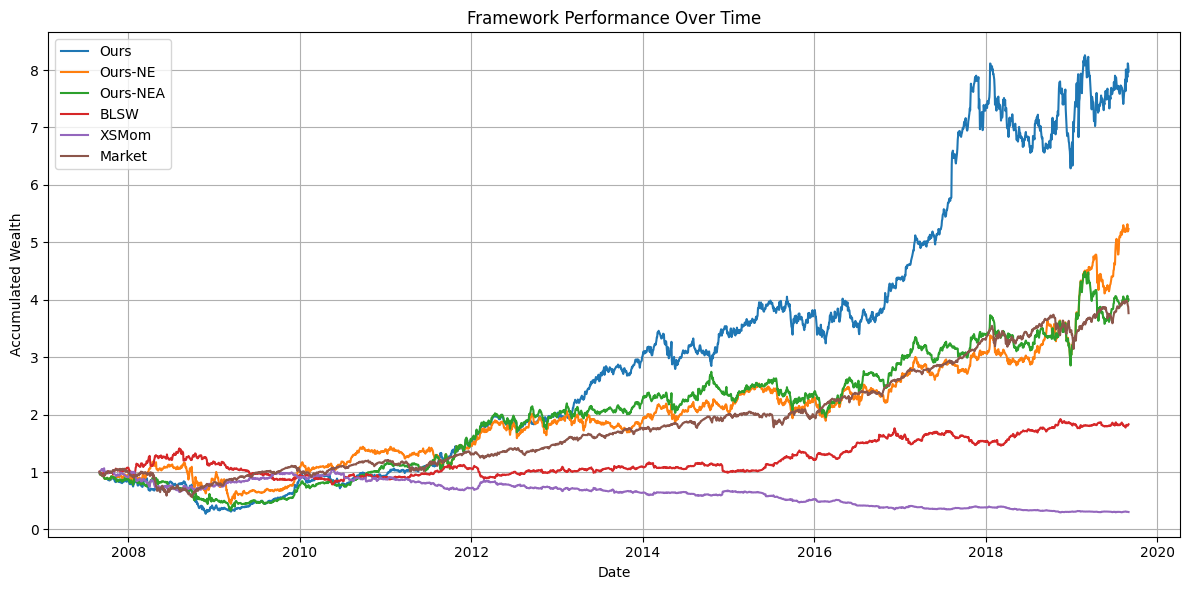

In [67]:
plot_cumulative_wealth(
    returns_dict={
        'Ours': model_result,
        'Ours-NE': model_ne_result,
        'Ours-NEA': model_nea_result,
        'BLSW': blsw_results[-len(model_nea_result):],
        # 'TSMom': tsmom_results[-len(model_nea_result):],
        'XSMom': xsmom_results[-len(model_nea_result):],
        'Market': market_results[-len(model_nea_result):]
    }, 
    start_time=datetime(2007, 9, 1, tzinfo=timezone.utc), 
    end_time=datetime(2019, 9, 1, tzinfo=timezone.utc)
)

In [78]:
results = {
        'Ours': model_result,
        'Ours-NE': model_ne_result,
        'Ours-NEA': model_nea_result,
        'BLSW': blsw_results[-len(model_nea_result):],
        # 'TSMom': tsmom_results[-len(model_nea_result):],
        'XSMom': xsmom_results[-len(model_nea_result):],
        'Market': market_results[-len(model_nea_result):]
    }
metrics = {}
for result_name, returns in results.items():
    metrics[result_name] = MetricsCalculator(
        metrics=DEFAULT_METRICS
    )(returns)
    

In [86]:
pd.DataFrame(metrics).to_csv('metrics.csv')

In [21]:
# pd.Series(all_runs_realized_returns[0]).to_csv('realized_returns_attention.csv')

In [83]:
from modeling.rl.metrics import MINUTES_PER_TRADING_YEAR, _to_numpy

In [77]:
MINUTES_PER_TRADING_YEAR

252.0

In [84]:
def APR(returns) -> float:
    """Annualised percentage return (CAGR)."""
    r = _to_numpy(returns)
    if r.size == 0:
        return float("nan")
    years = r.size / 252.0
    # Guard against division by zero for pathological inputs
    if years == 0:
        return float("nan")
    return float((np.prod(1.0 + r) ** (1.0 / years)) - 1.0)

In [85]:
APR(model_result)

0.21072798606756193